# Consigne : 

À partir du projet ci-dessous :
- interpréter systématiquement les indicateurs de performance de l’intelligence artificielle : 
    - Graphiques.
    - Métriques.
    - Généralisation. 
    - Vérification d'absence de data leakage.
    - Choix des methodes d'encodage.
    - Visualiser une learning curve.
    
**Les interprétations concernent le projet existant et les améliorations que vous allez apporter.**

- à partir des éléments d’interprétation, définir les caractéristiques des améliorations à apporter,
- intégrer les améliorations à l'algorithme d’intelligence artificielle (Réaliser au moins 2 itérations de plus),
- communiquer une estimation de charge au regard du besoin d’évolution de l’application
    - le livrable peut être, par exemple : un notebook, un excel, ou power point.
- intégrer l’évolution fonctionnelle (réaliser au minimum une API à partir de ce projet).
- tester la non régression de l’application suite à l’intégration de l’évolution
    - implémenter au moins 3 tests unitaires.
    - Assurez vous de gérer les erreurs d'entrée utilisateurs : 
        - exemple : que ce passe t-il si l'utilisateur rentre une chaine de caractère (string) alors que le modèle attend un entier (integer).

# Import des librairies et catalogue de fonctions

## Librairies

In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Type de modèles
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


# Entrainement du modèle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

# Sklearn : apprentissage automatique
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn import set_config # Pour afficher les pipelines

# Sklearn : preprocessing
from sklearn.preprocessing import LabelEncoder, LabelBinarizer, OrdinalEncoder, OneHotEncoder

import scipy.stats as stats
import pylab

import warnings
warnings.filterwarnings("ignore")

## Catalogue des fonctions

In [191]:
# Visualisation

def visualize_boxplot_object(df): 
    '''Boxplot des variables catégorielles associées à la target
    '''
    for col in df.select_dtypes('object'):
        plt.figure(figsize=(10,5))
        sns.boxplot(data=df, x=col, y="salary_in_usd")

        
def visualize_boxplot_numerical(df): 
    '''Boxplot des variables numériques associées à la target
    '''
    for col in df.select_dtypes('integer'):
        plt.figure(figsize=(10,5))
        sns.boxplot(data=df, x=col, y="salary_in_usd")

In [192]:
# Preprocessing

def encodage(df, job_encodage):
    ''' Correspond à toutes les étapes manuelles de preprocessing nécessaires à l'entrainement du modèle
        Job_encodage est à runner dans l'itération 2
        Employment_type sera à encoder avec du OneHot mais difficulté à faire fonctionner la fonction
    '''
    # transfo experience_level en ordinal
    df['xp_encoded'] = df[['experience_level']].replace({'EN': 0}).replace({'MI': 1}).replace({'SE': 2}).replace({'EX': 3})
    df = df.drop(['experience_level'], axis = 1)
    
    # ajout de job_title déjà encodée
    df = pd.merge(df, job_encodage, on = 'job_title')
    df = df.drop(['job_title'], axis = 1)
    
    # transfo company_location en ordinal
    df['company_location'][df['company_location'] != 'US'] = 0
    df['company_location'][df['company_location'] == 'US'] = 1
    df = df.astype({'company_location': int})
    
    # conversion de salary_in_usd en kilo $    
    df['salary_in_usd'] = df['salary_in_usd'] / 1000
    df = df.astype({'salary_in_usd': int})
    
    # transfo 'employment_type' en ordinal (à modifier en OneHot)
    df['employment_type_encoded'] = df[['employment_type']].replace({'FT' : 3}).replace({'PT' : 2}).replace({'CT' : 1}).replace({'FL' : 0})
    df = df.drop(['employment_type'], axis = 1)
    
    # transof 'company_size'
    df['size_encoded'] = df[['company_size']].replace({'S' : 0}).replace({'M' : 1}).replace({'L' : 2})
    df = df.drop(['company_size'], axis = 1)
        
    return df

def standardisation(df):
    scaler = StandardScaler()
    scaler.fit_transform(df)
    return df


def preprocessing(df):
    ''' Encodage et split
    '''
    
    df = encodage(df, job_encodage)
    df = standardisation(df)
    
    X = df.drop('salary_in_usd', axis=1)
    y = df['salary_in_usd']
    
    return X, y


def remove_outliers(df, df_columns):
    ''' Supprime les valeurs aberrantes en fonction du calcul des percentiles définis
        Bien indiquer le paramètre df_columns entre crochets (variables quantitatives)
    '''
    for col in df_columns:
        
        # Définit les percentiles 25% et 75% et calcule le IQR
        Q1 = np.percentile(df_columns[col], 25, interpolation = 'midpoint')
        Q3 = np.percentile(df_columns[col], 75, interpolation = 'midpoint')
        IQR = Q3 - Q1
 
        print("Old Shape: ", df.shape)
        
        # Détection des outliers (fourchette haute et basse)
        upper = np.where(df_columns[col] >= (Q3+1.5*IQR))
        lower = np.where(df_columns[col] <= (Q1-1.5*IQR))

        # Suppression des outliers
        df.drop(upper[0], inplace = True)
        df.drop(lower[0], inplace = True)
    
        print("New Shape: ", df.shape)

In [193]:
# Entrainement et score

def evaluation(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
    model.score(X_train, y_train)
    ypred = model.predict(X_test)
    
    print(f'Score R2 en cv : {cross_val_score(model, X_train, y_train, cv=5).mean()}')
    print(f'Score rmse en cv : {cross_val_score(model, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error").mean()}')
    print(f'Score R2 sur le train : {model.score(X_train, y_train)}')
    
    # Learning curve  
    
    visualizer = LearningCurve(model, cv=5, train_sizes=np.linspace(0.1, 1, 10), n_jobs=4)

    visualizer.fit(X_train, y_train) # Fit the data to the visualizer
    visualizer.show() # Finalize and render the figure
    
    print('------------------------------------------------')
    

def analyse_residus_linreg(model, X_train, y_train):
    y_hat = model.predict(X_train)
    residuals = y_hat - y_train
    
    
    sns.histplot(data=residuals, kde=True)
    plt.title('Distribution des résidus')
    plt.show()
    
    stats.probplot(residuals, dist="norm", plot=pylab)
    pylab.show()

# Récupération de la donnée

In [67]:
data = pd.read_csv('data/ds_salaries.csv', index_col=0)

In [68]:
data.head(5)

work_year experience_level employment_type                   job_title  \
0       2020               MI              FT              Data Scientist   
1       2020               SE              FT  Machine Learning Scientist   
2       2020               SE              FT           Big Data Engineer   
3       2020               MI              FT        Product Data Analyst   
4       2020               SE              FT   Machine Learning Engineer   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   70000             EUR          79833                 DE             0   
1  260000             USD         260000                 JP             0   
2   85000             GBP         109024                 GB            50   
3   20000             USD          20000                 HN             0   
4  150000             USD         150000                 US            50   

  company_location company_size  
0               DE            L  
1               JP            S  
2               GB            M  
3               HN            S  
4               US            L

**Définitions des colonnes :**



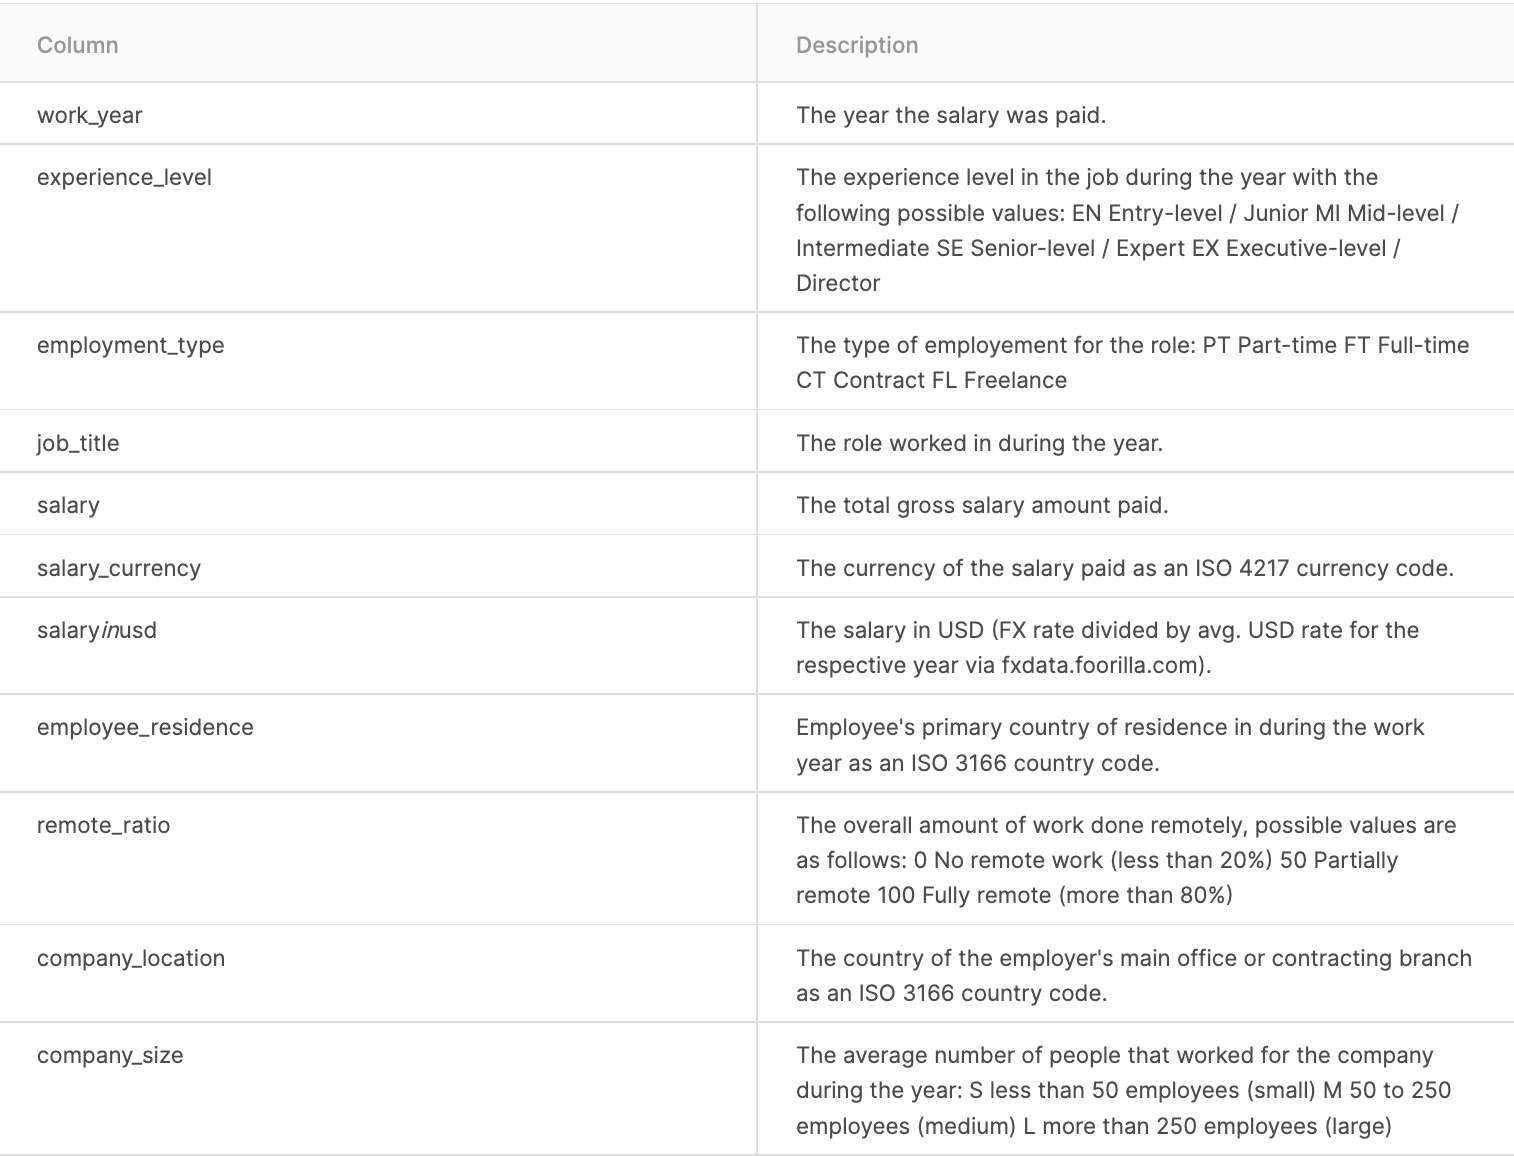

In [69]:
from IPython.display import Image
Image(filename='images/documentation.png') 

In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


**Interprétation**:  
Le dataset est composé de 11 features et 607 exemples. Il possède 4 colonnes numériques et 7 catégorielles. 

# - 1ère itération 

## Préparation de la données

In [71]:
data = data[['salary_in_usd','experience_level', 'job_title']]
data.head(2)

salary_in_usd experience_level                   job_title
0          79833               MI              Data Scientist
1         260000               SE  Machine Learning Scientist

**Interprétation** :  
Dans cette 1ère itération de modèle existant, seules les variables 'salary_in_usd' et 'experience_level' ont été retenues. On suppose qu'il s'agit de vérifier l'hypothèse commune qui consiste à penser que le salaire est relatif à l'expérience.

### Encodage de la colonne `experience_level` de manière ordinale

In [72]:
# Création d'une nouvelle colonne avec l'encodage nommée "xp_encoded"

data['xp_encoded'] = data[['experience_level']].replace({'EN': 0}).replace({'MI': 1}).replace({'SE': 2}).replace({'EX': 3})

**Interprétation**:
On suppose le choix d'un encodage ordinal car il y a une notion de hiérarchie dans le niveau d'expérience qu'il peut être important de retranscrire dans le modèle en affectant un poids plus important quand l'expérience est plus grande. 

In [73]:
# Visualisation du résultat

data.head(2)

salary_in_usd experience_level                   job_title  xp_encoded
0          79833               MI              Data Scientist           1
1         260000               SE  Machine Learning Scientist           2

In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 0 to 606
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   salary_in_usd     607 non-null    int64 
 1   experience_level  607 non-null    object
 2   job_title         607 non-null    object
 3   xp_encoded        607 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 23.7+ KB


In [75]:
# Conversion de la colonne 'xp_encoded' en int32 

data = data.astype({'xp_encoded': int})

### Convertion de la colonne `salary_in_usd` en kilo $

In [76]:
data['salary_in_usd'] = data['salary_in_usd'] / 1000

data = data.astype({'salary_in_usd': int})

In [77]:
data.head()

salary_in_usd experience_level                   job_title  xp_encoded
0             79               MI              Data Scientist           1
1            260               SE  Machine Learning Scientist           2
2            109               SE           Big Data Engineer           2
3             20               MI        Product Data Analyst           1
4            150               SE   Machine Learning Engineer           2

In [78]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 607 entries, 0 to 606
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   salary_in_usd     607 non-null    int32 
 1   experience_level  607 non-null    object
 2   job_title         607 non-null    object
 3   xp_encoded        607 non-null    int32 
dtypes: int32(2), object(2)
memory usage: 19.0+ KB


**Interprétation** : Ne perdons-nous pas de l'information en convertissant cette variable en K$, plutôt que de conserver le montant dans son intégralité ? 

## Data visualisation

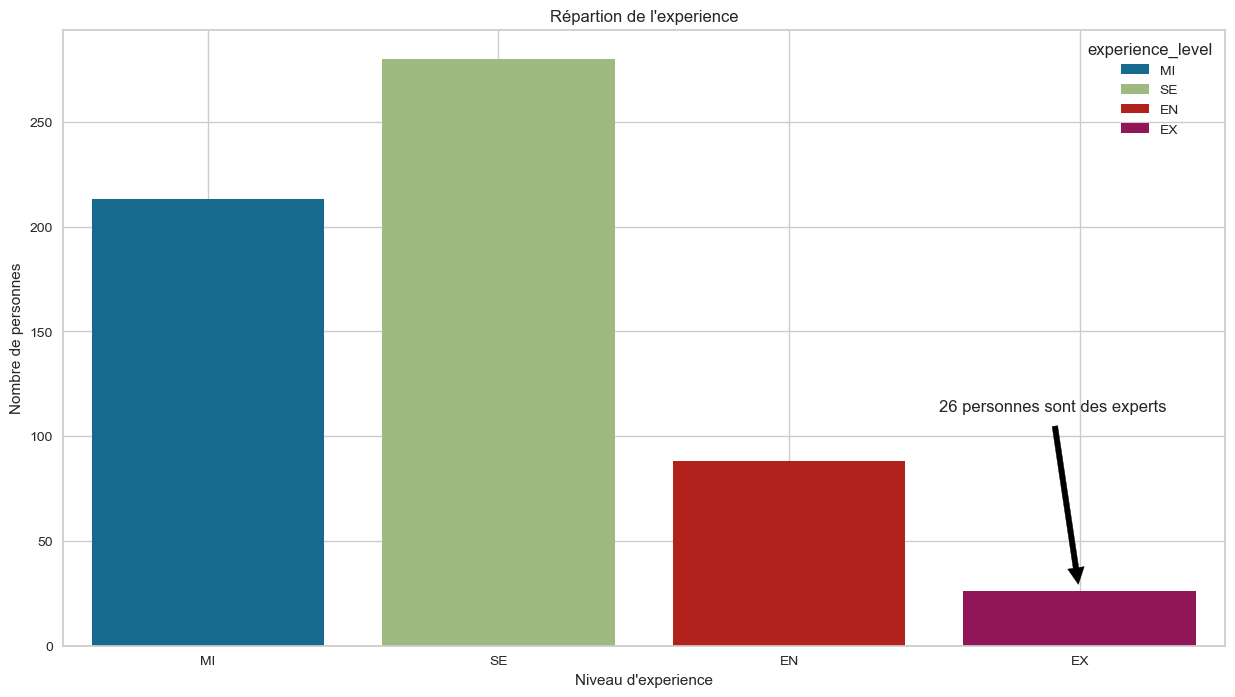

In [79]:
plt.figure(figsize=(15,8))
ax = sns.countplot(data=data,x='experience_level',  hue='experience_level', dodge=False)
ax.set_title("Répartion de l'experience")
ax.set_ylabel('Nombre de personnes')
ax.set_xlabel("Niveau d'experience")

ax.annotate('26 personnes sont des experts', xy=(3, 25),  xycoords='data',
            xytext=(0.95, 0.4), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',
            )
plt.grid(True)
plt.show()

**Interprétation** : 
Le countplot est un histogramme qui permet de figurer le nombre d'observations pour chaque catégorie. Ici, il s'agit d'analyer la répartition du niveau d'expérience parmi nos 607 observations. 
On constate que la catégorie la plus représentée est le niveau d'expérience intermédiaire (senior level) tandis que la moins représentée, celui des experts. 

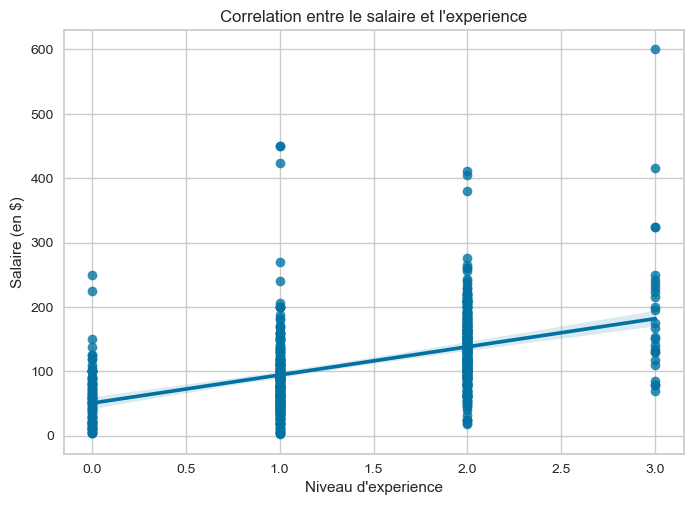

In [80]:
ax = sns.regplot(data=data,y='salary_in_usd', x='xp_encoded')
ax.set_title("Correlation entre le salaire et l'experience")
ax.set_ylabel('Salaire (en $)')
ax.set_xlabel("Niveau d'experience")
plt.grid(True)
plt.show()

**Il y a une corrélation positive entre le salaire et le niveau d'expérience**

**Interprétation** : 
Corrélation ne signifie pas causalité mais on peut supposer que le choix de la variable "niveau d'experience" peut nous donner un score intéressant. A noter la préence de possibles outliers. 

## ML - 1ère itération

In [81]:
# Import des librairies

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

In [82]:
# Définit les variables

y = data['salary_in_usd']
X = data[['xp_encoded']]

In [83]:
X.value_counts()

xp_encoded
2             280
1             213
0              88
3              26
dtype: int64

**Interpretation**:  
La target y est le salaire en dollar américain. Il s'agit de prédire le salaire en fonction du niveau d'expérience. 

In [84]:
# Split la data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

**Interprétation:** :  
On coupe le dataset en 2 échantillons selon la répartition indiquée dans le paramètre test_size:  
   - jeu d'entrainement (67%) sur lequel le modèle va s'entraîner
   - jeu de test (33%) sur lequel le modèle va appliquer ses scores afin d'évaluer la qualité du modèle     
   
On indique un random_state afin de conserver les mêmes valeurs dans les ensembles de données de train et de test à chaque fois qu'on run le code. 

In [85]:
# Score du modèle en cross_validation

score1_cv_r2 = cross_val_score(LinearRegression(),X_train,y_train, cv=5).mean()
score1_cv_r2

0.2312168924769316

In [86]:
score1_cv_rmse = cross_val_score(LinearRegression(),X_train,y_train, cv=5, scoring='neg_root_mean_squared_error').mean()
score1_cv_rmse

-62.3037001905338

**Interprétation**: 

La cross validation consiste à diviser le train en plusieurs échantillons (paramètres cv), eux-mêmes divisés en un train et un validation set, sur lequel sera testé le modèle et ses hyperparamètres choisis. Ainsi, le test set est préservé et on pourra comparer plusieurs modèles sans l'entâcher => évite l'overfitting. 

Le score présenté correspond à la moyenne des 5 échantillons testés (cv) pour notre modèle de régression linéaire dont les paramètres n'ont pas du tout étaient optimisés. Par défaut, le score est le coefficient de détermination. Ce modèle obtient un R2 de 0.23 : la variable niveau d'expérience 'xp_encoded' explique à elle seule 23% de la variance du salaire. Le R2 étant proche de 0, le score est considéré mauvais. 

La stratégie initiale a été, malgré un score en cross_validation peu convaincant, de tester le modèle de régression sur le test alors que notre démarche aurait été d'analyser plus précisément pourquoi le score en cross validation est mauvais et comment l'améliorer. Ce que nous ferons juste après. 

In [87]:
# Modèle de régression linéaire

lr_1 = LinearRegression()

In [88]:
# Entraînement du modèle sur le train

lr_1.fit(X_train,y_train)

LinearRegression()

In [89]:
# Vérification du coefficient

lr_1.coef_

array([45.74363686])

`Interpreter : `

Il s'agit du coefficient associé à la variable "niveau d'expérience". Si notre variable augmente de 1, alors Y augmente de 45,74. 

In [90]:
# Score sur le test

lr_1.score(X_test,y_test)

0.17677492181930476

`Interpreter : `

On évalue le R2 sur les données de test de notre jeu de données : 17% de la variabilité du salaire autour de la moyenne est expliqué par notre modèle. 

**Testing d'autres modèles**

In [91]:
cross_val_score(RandomForestRegressor(),X_train,y_train, cv=5).mean()

0.2237264395738805

In [92]:
cross_val_score(SVR(),X_train,y_train, cv=5).mean()

0.139946976467299

**Interprétation:** 

Les scores ne sont guère mieux avec deux autres modèles   
NOTE : et s'interroger sur la pertinence d'utiliser ces 2 types de modèles

Analysons plus précisément le comportement de notre modèle pour en savoir plus sur les actions d'amélioration à mener. Pour cela, nous allons nous aider de la learning curve.

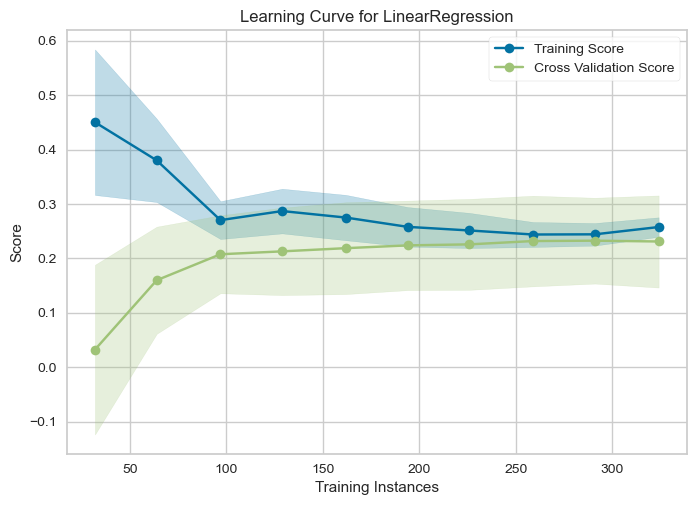

In [93]:
# Analyse de la learning curve sur le jeu de validation croisée

from yellowbrick.datasets import load_game
from yellowbrick.model_selection import LearningCurve



# visualizer = LearningCurve(
#     lr_1, cv=5, train_sizes=train_sizes, n_jobs=4
# )

visualizer = LearningCurve(
    lr_1, cv=5, train_sizes=np.linspace(0.1, 1, 10), n_jobs=4
                                       )



visualizer.fit(X_train, y_train) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure
plt.show()

**Interprétation :**
La learning curve montre la relation entre le training score et le validation test score. Son analyse va nous permettre de savoir si notre estimateur bénéficie d'assez de données et s'il est plus sensible au biais ou à la variance (aux problèmes d'overfitting ou d'underfitting). 

Les scores du training set et du validation set convergent à mesure que de la donnée est ajoutée. Par ailleurs, le score du train diminue tandis que celui du test augmente : cela indique que nous ne semblons pas être en overfitting (notre estimateur ne semble pas apprendre par coeur des données car il parvient à scorer de mieux en mieux sur des données qu'il ne connait pas). Par conséquent, notre modèle semble bien généraliser. 

Néanmoins, il faut relativiser. Les erreurs restent élevées sur le train et le test (avec un score R2 autour de 0,23), avec l'hypothèse d'un problème de biais. En effet, la variabilité autour du validation set, représentée par la zone colorée verte, est très élevée : l'écart-type autour de la moyenne est donc important. Cela peut signifier que notre modèle n'a pas réussi à faire suffisamment de relations pertinentes entre nos données d'entrées et de sortie. On pourrait supposer un modèle qui underfit, sa fonction coût est élevée et il souffre d'un grand biais. 

Notre modèle souffrirait sûrement d'un manque de features, il ne parvient pas à capturer le corrélations du jeu d'entraînement. Il semble trop simple pour découvrir la structure sous-jacente des données. 

Score R2 en cv : 0.2312168924769316
Score rmse en cv : -62.3037001905338
Score R2 sur le train : 0.2577188685151198


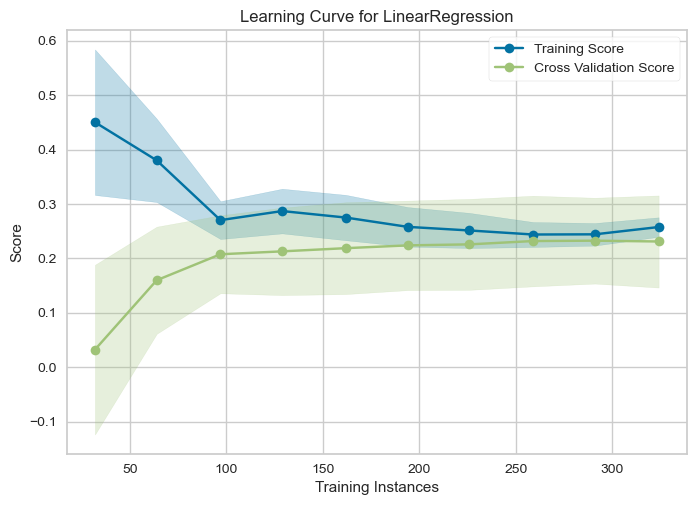

------------------------------------------------


In [94]:
iteration_1 = evaluation(model, X_train, y_train, X_test, y_test)

## Analyse des caractéristiques d'amélioration à apporter 

Au regard de cette première itération, la première chose qu'il nous semble pertinent de faire est d'ajouter des features à notre modèle car comme vu précédemment, il a tendance à underfitter et notre R2 est mauvais. Ces features seront sélectionnées en fonction des résultats de l'EDA et de nouvelles features créées au besoin (feature engineering). 

On pourra dans un second temps nous demander si la régression linéaire est le modèle le plus pertinent au vu de nos features. Observe-t-on une tendance normale dans nos données (=> application de modèles paramétriques) ? Par ailleurs, nous avons beaucoup de variables catégorielles et notre dataset est petit, il pourrait donc être intéressant de tester le Decision tree.  

Une fois le/les modèles choisis, il conviendra d'en optimiser les hyperparamètres afin de régler au mieux les performances de l'algorithme. 

# - 2 éme itération :

In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Datavisualisation

In [96]:
data_2 = pd.read_csv('data/ds_salaries.csv', index_col=0)
data_2

work_year experience_level employment_type                   job_title  \
0         2020               MI              FT              Data Scientist   
1         2020               SE              FT  Machine Learning Scientist   
2         2020               SE              FT           Big Data Engineer   
3         2020               MI              FT        Product Data Analyst   
4         2020               SE              FT   Machine Learning Engineer   
..         ...              ...             ...                         ...   
602       2022               SE              FT               Data Engineer   
603       2022               SE              FT               Data Engineer   
604       2022               SE              FT                Data Analyst   
605       2022               SE              FT                Data Analyst   
606       2022               MI              FT                AI Scientist   

     salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0     70000             EUR          79833                 DE             0   
1    260000             USD         260000                 JP             0   
2     85000             GBP         109024                 GB            50   
3     20000             USD          20000                 HN             0   
4    150000             USD         150000                 US            50   
..      ...             ...            ...                ...           ...   
602  154000             USD         154000                 US           100   
603  126000             USD         126000                 US           100   
604  129000             USD         129000                 US             0   
605  150000             USD         150000                 US           100   
606  200000             USD         200000                 IN           100   

    company_location company_size  
0                 DE            L  
1                 JP            S  
2                 GB            M  
3                 HN            S  
4                 US            L  
..               ...          ...  
602               US            M  
603               US            M  
604               US            M  
605               US            M  
606               US            L  

[607 rows x 11 columns]

In [97]:
data_2.head()

work_year experience_level employment_type                   job_title  \
0       2020               MI              FT              Data Scientist   
1       2020               SE              FT  Machine Learning Scientist   
2       2020               SE              FT           Big Data Engineer   
3       2020               MI              FT        Product Data Analyst   
4       2020               SE              FT   Machine Learning Engineer   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   70000             EUR          79833                 DE             0   
1  260000             USD         260000                 JP             0   
2   85000             GBP         109024                 GB            50   
3   20000             USD          20000                 HN             0   
4  150000             USD         150000                 US            50   

  company_location company_size  
0               DE            L  
1               JP            S  
2               GB            M  
3               HN            S  
4               US            L

In [98]:
# Calcule du nombre d'exemples par intitulé de poste

data_2_group_count = data_2.groupby('job_title',as_index=False).count()
# data_2_group_count = data_2_group_count[['job_title','work_year']]

In [99]:
# Classement des jobs les plus rémunérés 

data_2_group_mean = data_2.groupby('job_title',as_index=False).mean()[['job_title','salary_in_usd']].sort_values(by='salary_in_usd',ascending=False)

In [100]:
data_2_group_mean['salary_in_usd'] = data_2_group_mean['salary_in_usd'] / 1000
data_2_group_mean = data_2_group_mean.astype({'salary_in_usd': int})
data_2_group_mean = data_2_group_mean.rename(columns={'salary_in_usd': 'Salaire moyen ( en kilo $ )'})

In [101]:
data_2_group_mean_count = data_2_group_mean.merge(data_2_group_count,left_on='job_title',right_on='job_title')

In [102]:
data_2_group_mean_count = data_2_group_mean_count.rename(columns={'work_year': 'Nombre de salaire'})

In [103]:
# data_2_group_mean_count.info()

In [104]:
# data_2_group_mean_count.head(2)

In [105]:
# data_2_group_mean_count[[data_2_group_mean_count.columns[2]]]

In [106]:
# data_2_group_mean_count

In [107]:
# data_2_group_mean_count.head(2).info()

In [108]:
# data_2_group_mean_count

In [109]:
y = data_2_group_mean_count['Salaire moyen ( en kilo $ )']
x = data_2_group_mean_count['job_title']

In [110]:
import plotly.express as px

fig = px.scatter(x=x, y=y)
fig.update_layout(width=int(1000),height=int(800))
fig.show()

**Interprétation** : 

Ce graph permet de mettre en évidence une hiérarchie de salaire selon le job occupé. Cette donnée peut être intéressante car elle introduit la notion de hiérarchie dans la feature "job title".  
Notre idée serait alors soit d'encoder cette variable catégorielle de façon ordinale (en instaurant une hiérarchie de poids dans les métiers proportionnelle au salaire moyen), soit d'ajouter la feature salaire moyen. 

## Préparation des données

L'application de machine learning de base s'arrêtait là.  
Nous continuons donc cette seconde itération dans l'optique de répondre aux perspectives d'analyse que nous avons avancées en conclusion de l'itération 1.  

Nous allons donc ajouter la variable 'job title' à notre modèle existant, en espérant améliorer notre R2. 

### Création de la variable `job_title` de manière ordinale (encodage)

In [111]:
# Création dataframe sur la base du classement des jobs par le salaire moyen
job_encodage = data_2_group_mean_count
job_encodage.head(2)

job_title  Salaire moyen ( en kilo $ )  Nombre de salaire  \
0      Data Analytics Lead                          405                  1   
1  Principal Data Engineer                          328                  3   

   experience_level  employment_type  salary  salary_currency  salary_in_usd  \
0                 1                1       1                1              1   
1                 3                3       3                3              3   

   employee_residence  remote_ratio  company_location  company_size  
0                   1             1                 1             1  
1                   3             3                 3             3

In [112]:
# Création d'une liste ordinale
classement = list(range(0, len(job_encodage)))
classement.sort(reverse = True)

In [113]:
# On ajoute une colonne au df pour y accoler un classement
job_encodage['job_ordinal'] = classement
job_encodage.head(5)

job_title  Salaire moyen ( en kilo $ )  Nombre de salaire  \
0       Data Analytics Lead                          405                  1   
1   Principal Data Engineer                          328                  3   
2    Financial Data Analyst                          275                  2   
3  Principal Data Scientist                          215                  7   
4  Director of Data Science                          195                  7   

   experience_level  employment_type  salary  salary_currency  salary_in_usd  \
0                 1                1       1                1              1   
1                 3                3       3                3              3   
2                 2                2       2                2              2   
3                 7                7       7                7              7   
4                 7                7       7                7              7   

   employee_residence  remote_ratio  company_location  company_size  \
0                   1             1                 1             1   
1                   3             3                 3             3   
2                   2             2                 2             2   
3                   7             7                 7             7   
4                   7             7                 7             7   

   job_ordinal  
0           49  
1           48  
2           47  
3           46  
4           45

In [114]:
# On sélectionne les deux colonnes qui nous intéresse
job_encodage = job_encodage[['job_title', 'job_ordinal']]
job_encodage.head(5)

job_title  job_ordinal
0       Data Analytics Lead           49
1   Principal Data Engineer           48
2    Financial Data Analyst           47
3  Principal Data Scientist           46
4  Director of Data Science           45

### Conversion de la colonne  `experience_level` & salary_in_usd de l'itération 1

In [115]:
# On reprend le preprocessing effectué lors de l'itération 1 
data_2 = data_2[['salary_in_usd', 'experience_level', 'job_title']]

In [116]:
# Création d'une nouvelle colonne avec l'encodage nommée "xp_encoded"

data_2['xp_encoded'] = data_2[['experience_level']].replace({'EN': 0}).replace({'MI': 1}).replace({'SE': 2}).replace({'EX': 3})

In [117]:
# Transformation de la colonne salaire en K$

data_2['salary_in_usd'] = data_2['salary_in_usd'] / 1000
data_2 = data_2.astype({'salary_in_usd': int})

In [118]:
data_2.head(5)

salary_in_usd experience_level                   job_title  xp_encoded
0             79               MI              Data Scientist           1
1            260               SE  Machine Learning Scientist           2
2            109               SE           Big Data Engineer           2
3             20               MI        Product Data Analyst           1
4            150               SE   Machine Learning Engineer           2

In [119]:
data_2_merge = pd.merge(data_2, job_encodage, on = 'job_title')
data_2_merge

salary_in_usd experience_level                       job_title  \
0               79               MI                  Data Scientist   
1               35               MI                  Data Scientist   
2               51               EN                  Data Scientist   
3               40               MI                  Data Scientist   
4               39               EN                  Data Scientist   
..             ...              ...                             ...   
602             54               MI                   ETL Developer   
603             79               EX        Head of Machine Learning   
604             37               MI                    NLP Engineer   
605             87               SE  Lead Machine Learning Engineer   
606            405               SE             Data Analytics Lead   

     xp_encoded  job_ordinal  
0             1           24  
1             1           24  
2             0           24  
3             1           24  
4             0           24  
..          ...          ...  
602           1            5  
603           3           13  
604           1            2  
605           2           15  
606           2           49  

[607 rows x 5 columns]

## Data visualisation

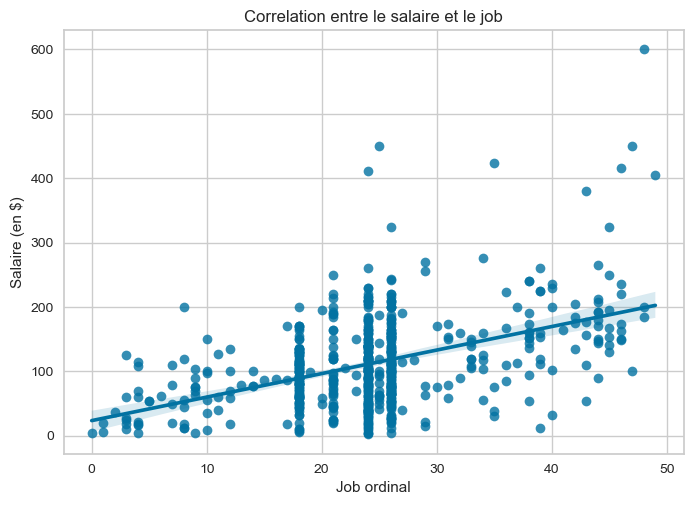

In [120]:
# Visualisation 

ax = sns.regplot(data=data_2_merge,y='salary_in_usd', x='job_ordinal')
ax.set_title("Correlation entre le salaire et le job")
ax.set_ylabel('Salaire (en $)')
ax.set_xlabel("Job ordinal")
plt.grid(True)
plt.show()

In [121]:
data_2_merge.corr()

salary_in_usd  xp_encoded  job_ordinal
salary_in_usd       1.000000    0.483866     0.454694
xp_encoded          0.483866    1.000000     0.269731
job_ordinal         0.454694    0.269731     1.000000

**Interprétation** : 
Sans surprise, on note une corrélation positive entre le job et le salaire. En revanche, nous constatons la présence d'outliers qu'il conviendrait de gérer car notre modèle, la régression linéaire, est sensible aux outliers. 

## ML - 2ème itération

L'objectif est de scorer notre modèle dans les mêmes conditions que lors de la 1ère itération afin de voir si l'ajout d'une variable a permis d'améliorer le modèle. 

In [122]:
y_2 = data_2_merge['salary_in_usd']
X_2 = data_2_merge[['xp_encoded', 'job_ordinal']]

In [123]:
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.33, random_state=42)

In [124]:
score2_cv_r2 = cross_val_score(LinearRegression(),X_train_2,y_train_2, cv=5).mean()
score2_cv_r2

0.3420014414582511

In [125]:
score2_cv_rmse = cross_val_score(LinearRegression(),X_train_2,y_train_2, cv=5, scoring='neg_root_mean_squared_error').mean()
score2_cv_rmse

-53.080412254681654

**Interprétation :**  
Notre score en cross_validation avec 2 features s'est amélioré : nous sommes passés d'un R2 de 0.23 à 0.34.
Dans la mesure où nous avons constaté qu'il y avait des valeurs aberrantes, il peut être intéressant d'associer au R2, la RMSE qui va pénaliser les erreurs importantes (cherche d'abord la moyenne des écarts au carré avant d'en extraire la racine carrée).

In [126]:
# Scores de l'itération 1 

score1_cv_r2, score1_cv_rmse

(0.2312168924769316, -62.3037001905338)

**Interprétation :**  
On réduit l'erreur de notre modèle en ajoutant la variable 'job_ordinal' mais le résultat reste insatisfaisant. 

In [199]:
#############################################
# SCore sur notre test et analyse ds résidus 
############################################

# Score model sur le X_train avec Sklearn

model = LinearRegression()
model.fit(X_train_2, y_train_2)
model.score(X_train_2, y_train_2)

# Score sur notre test
model.score(X_test_2, y_test_2)

0.3240199462698522

Score R2 en cv : 0.3420014414582511
Score rmse en cv : -53.080412254681654
Score R2 sur le train : 0.351516926351085


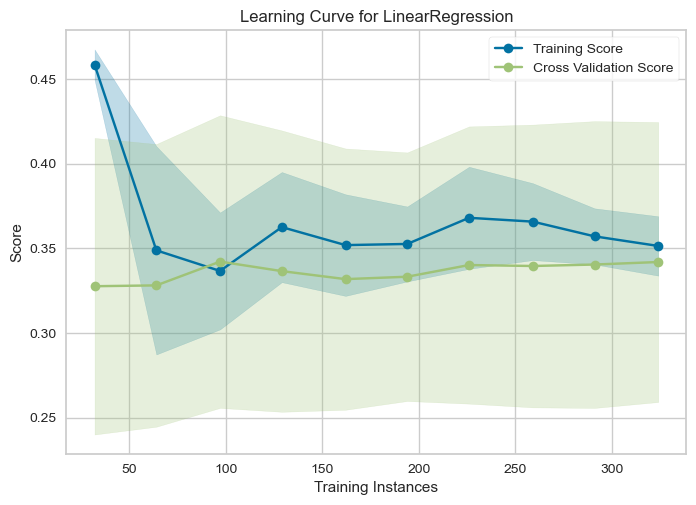

------------------------------------------------


In [128]:
iteration_2 = evaluation(model, X_train_2, y_train_2, X_test_2, y_test_2)

**Interprétation** : 

Notre score sur le test est quasiment identique à notre score en cross validation (=> toujours pas d'overfitting).

In [196]:
def analyse_residus_linreg(model, X_train, y_train):
    y_hat = model.predict(X_train)
    residuals = y_hat - y_train
    
    
    sns.histplot(data=residuals, kde=True)
    plt.title('Distribution des résidus')
    plt.show()
    
    stats.probplot(residuals, dist="norm", plot=pylab)
    pylab.show()

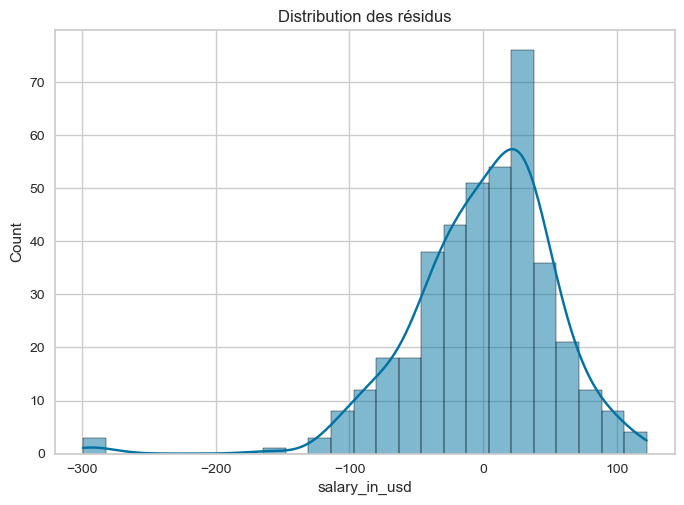

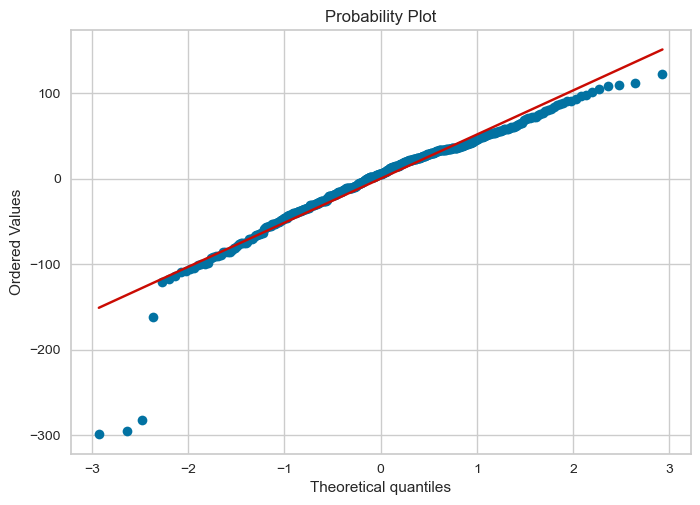

In [198]:
analyse_residus_linreg(model, X_train_2, y_train_2)

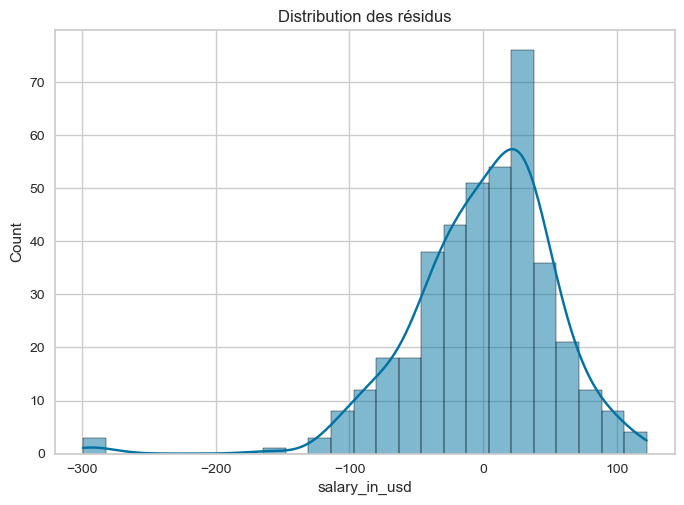

In [129]:
# Residual plot et distribution du X_train

y_hat = model.predict(X_train_2)
residuals = y_hat - y_train_2

sns.histplot(data=residuals, kde=True)
plt.title('Distribution des résidus')
plt.show()

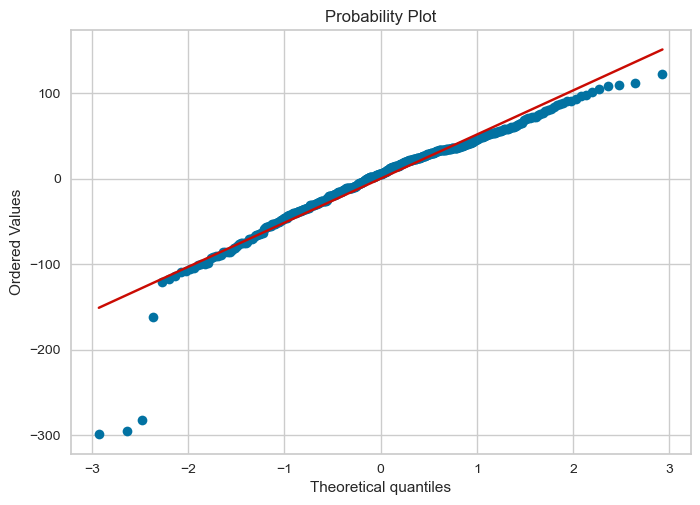

In [130]:
# QQ plot : permet de vérifier si la distribution suit une loi normale

stats.probplot(residuals, dist="norm", plot=pylab)
pylab.show()

**Interprétation:** : 
L'analyse de résidus et leur distribution montre que notre modèle semble suivre une tendance gaussienne, ce qui confirme notre choix de ce modèle paramétrique. En revanche, cela met en avant le fait que nous ayons des outliers qu'il va nous falloir gérer pour améliorer notre modèle.

## Analyse des caractéristiques d'amélioration à apporter 

Suite à cette deuxième itération, il nous faut : 
- ajouter des features à notre modèle et effectuer une datavisualisation plus poussée
- gérer les outliers
- réguler les hyperparamètres
- bien que notre dataset soit petit et que l'algorithme de minimisation de l'erreur intégré à la fonction (méthode des moindres carrés) semble adapté, il peut être intéressant d'utiliser le SGD Regressor afin que nous puissions chercher à miniser l'erreur avec la Descente de Gradient. Nous pourrons ainsi plus moduler les hyperparamètres mais SGD est plus efficace avec les échantillons > 10000 (ce qui est loin d'être notre cas). 
- Test du Decision tree (car beaucoup de variables catégorielles)

In [131]:
# Que faire d'un scatterplot entre une variable quantitative et qualitative ? 
# Est-ce que cela nous montre qu'il y aurait un intérêt algorithmique à encoder les variables métier de façon ordinale
# OU qu'il faut associer au dataset cette nouvelle feature "salaire moyen en kilo $" ?

# => encoder de façon ordinale le job en lui donnant une pondération relative au salaire moyen.
# => ou récupérer tout simplmement le salaire moyen

# => vérifier si notre modèle est sensible aux outliers 

# - 3 éme itération 

Avant de ré-entraîner notre modèle, nous allons procéder à l'analyse exploratoire des données qui nous permettra de mieux en connaitre la structure et de préparer nos données de façon optimum afin que les algorithmes de machine learning puissent être plus performants. 

## EDA 

### Analyse de forme 

- Identification de la target : salary_in_usd  
- Nb lignes et colonnes : 607 lignes et 11 colonnes
- Types de variables : 4 variables quantitatives et 7 catégorielles
- Identification des valeurs manquantes : aucune

In [220]:
data_3 = pd.read_csv('data/ds_salaries.csv', index_col=0)

In [221]:
data_3

work_year experience_level employment_type                   job_title  \
0         2020               MI              FT              Data Scientist   
1         2020               SE              FT  Machine Learning Scientist   
2         2020               SE              FT           Big Data Engineer   
3         2020               MI              FT        Product Data Analyst   
4         2020               SE              FT   Machine Learning Engineer   
..         ...              ...             ...                         ...   
602       2022               SE              FT               Data Engineer   
603       2022               SE              FT               Data Engineer   
604       2022               SE              FT                Data Analyst   
605       2022               SE              FT                Data Analyst   
606       2022               MI              FT                AI Scientist   

     salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0     70000             EUR          79833                 DE             0   
1    260000             USD         260000                 JP             0   
2     85000             GBP         109024                 GB            50   
3     20000             USD          20000                 HN             0   
4    150000             USD         150000                 US            50   
..      ...             ...            ...                ...           ...   
602  154000             USD         154000                 US           100   
603  126000             USD         126000                 US           100   
604  129000             USD         129000                 US             0   
605  150000             USD         150000                 US           100   
606  200000             USD         200000                 IN           100   

    company_location company_size  
0                 DE            L  
1                 JP            S  
2                 GB            M  
3                 HN            S  
4                 US            L  
..               ...          ...  
602               US            M  
603               US            M  
604               US            M  
605               US            M  
606               US            L  

[607 rows x 11 columns]

In [222]:
data_3.head()

work_year experience_level employment_type                   job_title  \
0       2020               MI              FT              Data Scientist   
1       2020               SE              FT  Machine Learning Scientist   
2       2020               SE              FT           Big Data Engineer   
3       2020               MI              FT        Product Data Analyst   
4       2020               SE              FT   Machine Learning Engineer   

   salary salary_currency  salary_in_usd employee_residence  remote_ratio  \
0   70000             EUR          79833                 DE             0   
1  260000             USD         260000                 JP             0   
2   85000             GBP         109024                 GB            50   
3   20000             USD          20000                 HN             0   
4  150000             USD         150000                 US            50   

  company_location company_size  
0               DE            L  
1               JP            S  
2               GB            M  
3               HN            S  
4               US            L

In [223]:
data_3.shape

(607, 11)

In [224]:
data_3.dtypes.value_counts()

object    7
int64     4
dtype: int64

In [225]:
data_3.isna().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

### Analyse de fond

- Analyse de la target : distribution légèrement asymétrique vers la droite avec des outliers en queue de distribution => envisager d'appliquer logarithme, standardisation suffit ? et de supprimer les valeurs aberrantes. 

- Signification des variables :
  
    - variables numériques discrètes :   
     'Remote_ratio' montre que plus de la moitié des salariés sont en télétravail -> serait intéressant de le combiner avec une culture d'entreprise (employee residence/company_location/company size) et voir si cette variable peut être discriminante + présence d'outliers pour la variable 'salary'
    - variables qualitatives :   
     La plupart des salariés sont employés à temps plein et une grande majorité sont d'un niveau junior ou senior (faire une variable binaire -> junior/senior ?) Une majorité concerne des entreprises de taille moyenne ou large.
     Les entreprises de moyenne taille ont tendance à pratiquer davantage de télétravail que les petites ou grandes entreprises (proportionnellement).
     On constate aussi la présence de variables avec des classes très déséqulibrées. ex : employement_type, company_location
     
- Corrélations entre les variables : 
    - des variables numériques : pas de relation linéaire significative entre les variables, ni avec la target. 
    - ...

Conclusion :   
    - gérer les outliers et standardiser les données
    - créer du feature engineering, notamment pour les variables catégorielles qu'il va falloir encoder et qui présente un déqéquilibre des classes

#### Visualisation de la target

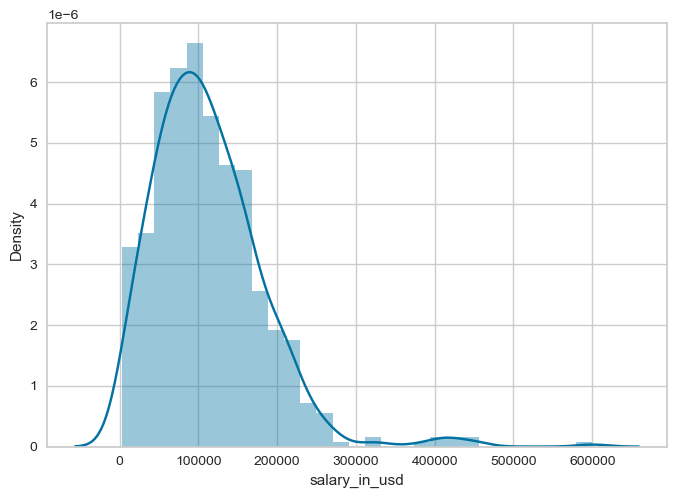

In [226]:
sns.distplot(data_3['salary_in_usd'], label = 'salary_in_usd')
plt.show()

In [227]:
data_3['salary_in_usd'].describe()

count       607.000000
mean     112297.869852
std       70957.259411
min        2859.000000
25%       62726.000000
50%      101570.000000
75%      150000.000000
max      600000.000000
Name: salary_in_usd, dtype: float64

In [228]:
data_3.dtypes

work_year              int64
experience_level      object
employment_type       object
job_title             object
salary                 int64
salary_currency       object
salary_in_usd          int64
employee_residence    object
remote_ratio           int64
company_location      object
company_size          object
dtype: object

L'analyse nous montre que notre distribution est biaisée à droite et que nous avons des outliers en queue de distribution. 
Il pourra alors être intéressant soit d'appliquer un log à notre analyse ou de gérer les outliers, d'autant que notre modèle de regression linéaire est sensible aux distributions normales et aux outliers.
=> appliquer un log/standardisation suffisante + gestion des outliers

Le salaire moyen est de 112K dollars, le minimum étant de 2K dollars et le maximum de 600K dollars.  
75% des salaires se situent en dessous de 150$ => certaines valeurs extrêmes vont être susceptibles d'influencer négativement notre modèle. Différence entre la moyenne et la médiane confirme la présence d'outliers.

#### Visualisation des variables numériques discrètes

Le boxplot va nous permettre d'analyser la distribution de nos variables et de tracer les valeurs médianes, les valeurs aberrantes et les quartiles.

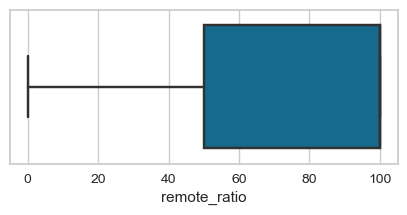

In [217]:
plt.figure(figsize=(5,2))
sns.boxplot(data=data_3, x="remote_ratio")
plt.show()

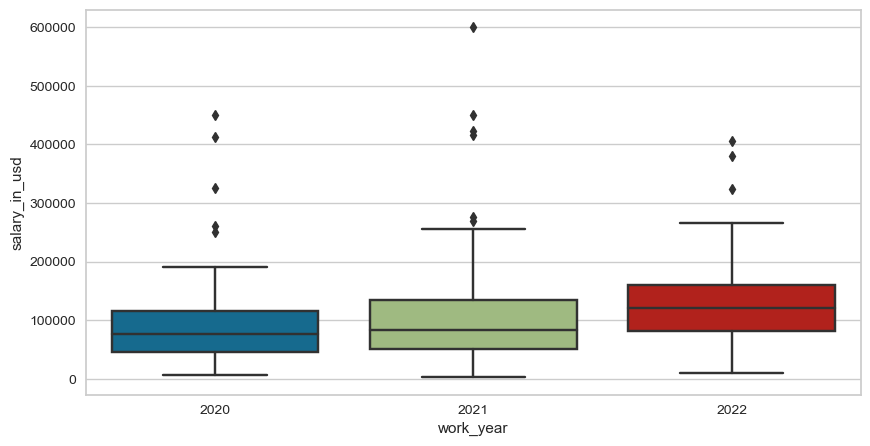

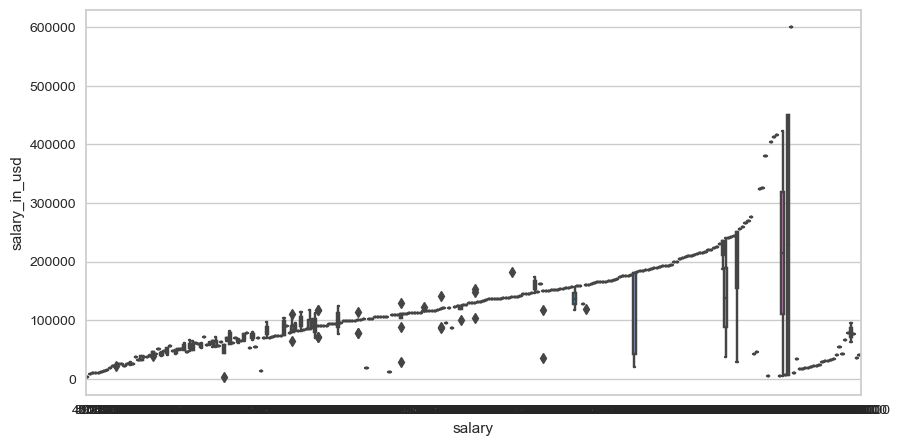

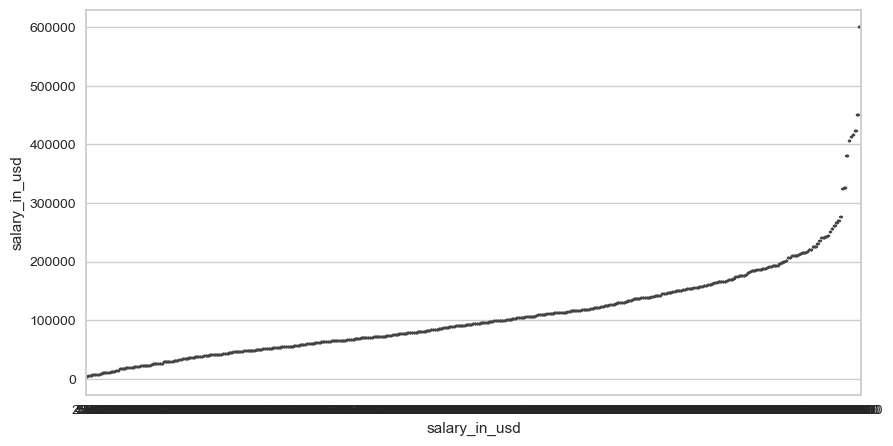

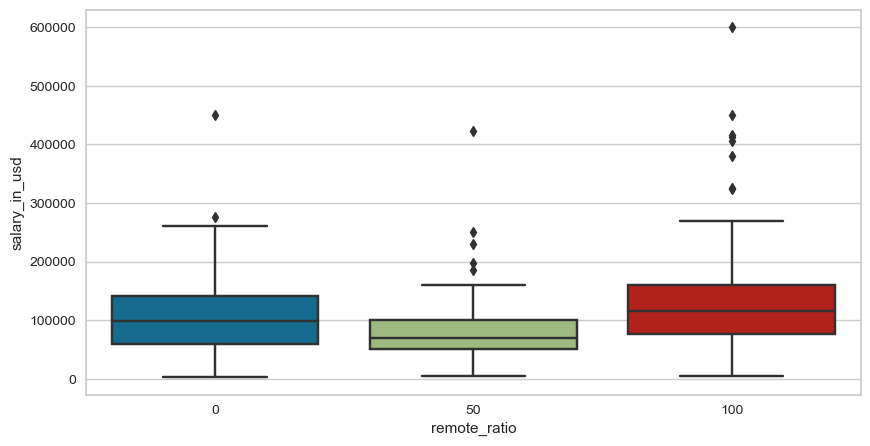

In [141]:
visualize_boxplot_numerical(data_3)

In [229]:
data_3['remote_ratio'].describe()

count    607.00000
mean      70.92257
std       40.70913
min        0.00000
25%       50.00000
50%      100.00000
75%      100.00000
max      100.00000
Name: remote_ratio, dtype: float64

**Interprétation :**

La variable 'salary' montre des outliers très importants.  
'Remote_ratio' est intéressante car elle nous permet de constater que 50% des salariés sont considérés en full télétravail, correspondant au maximum de ce qui est possible d'avoir (max = 100). On pourrait mettre en relation cette variable avec la localisation de l'entreprise ou de résidence du salarié (pourrait mettre en avant des cultures d'entreprise). 

#### Visualisation des variables catégorielles

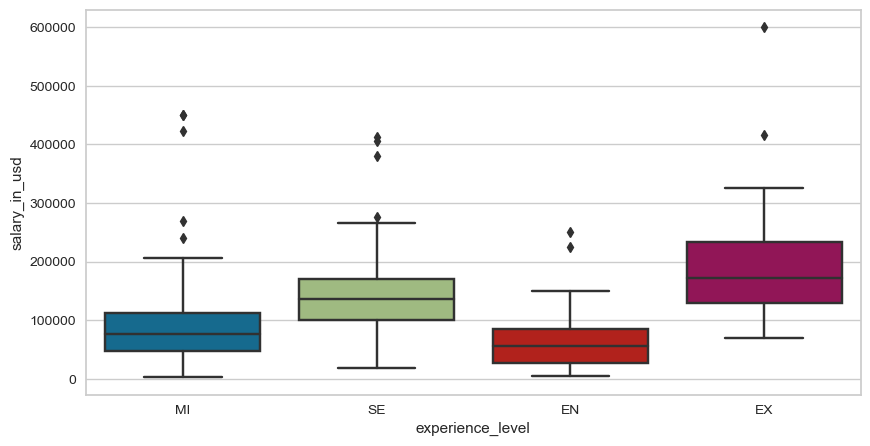

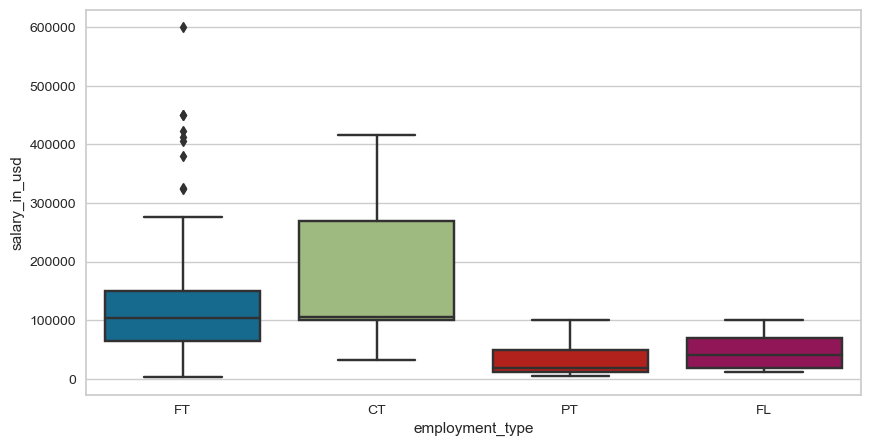

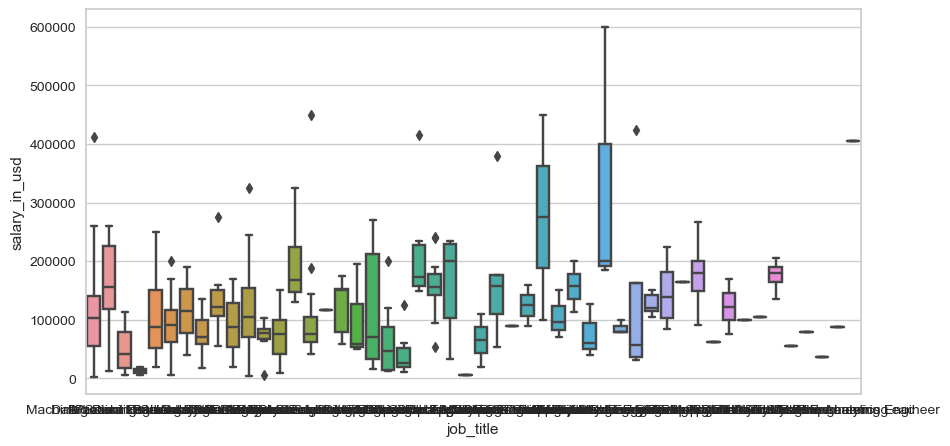

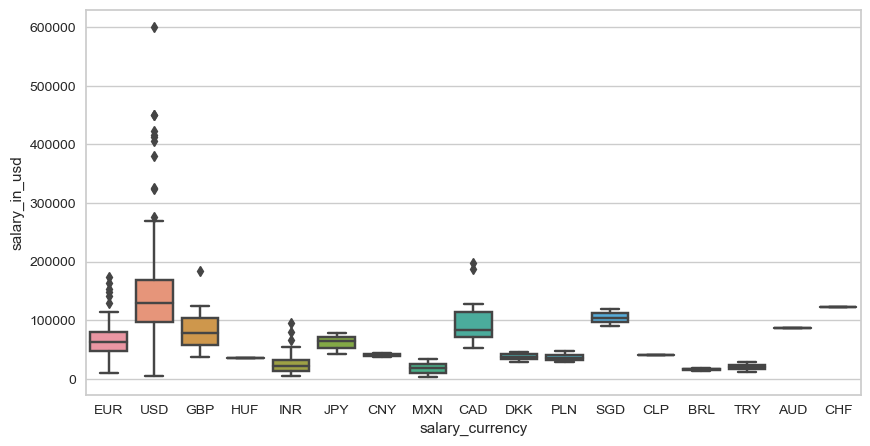

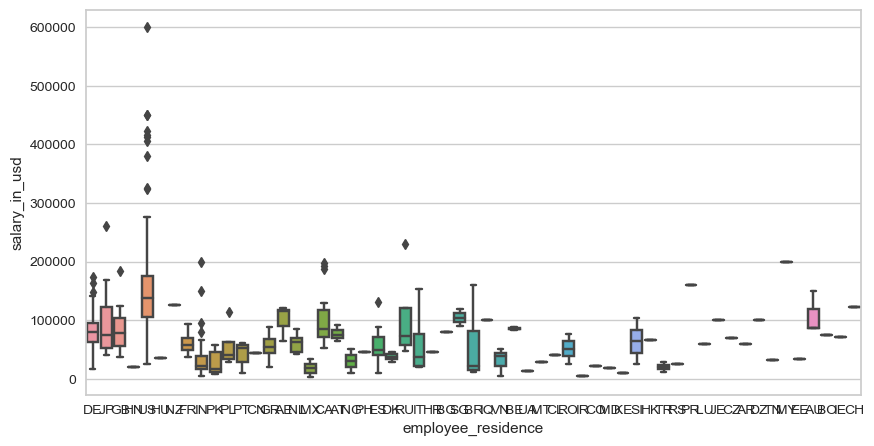

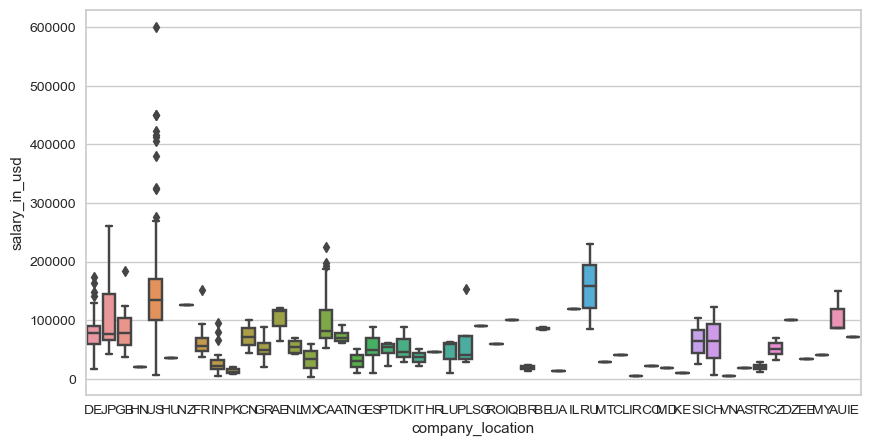

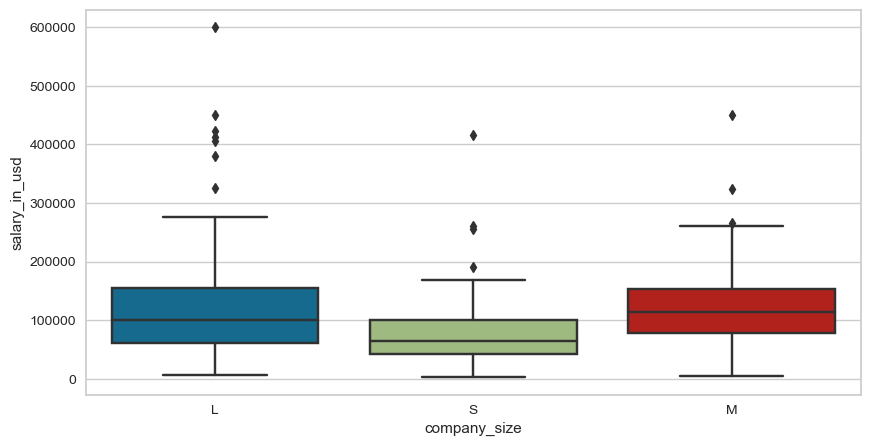

In [143]:
visualize_boxplot_object(data_3)

In [144]:
for col in data_3.select_dtypes('object'):
    print(f'{col :-<80}, {data_3[col].unique()}')

experience_level----------------------------------------------------------------, ['MI' 'SE' 'EN' 'EX']
employment_type-----------------------------------------------------------------, ['FT' 'CT' 'PT' 'FL']
job_title-----------------------------------------------------------------------, ['Data Scientist' 'Machine Learning Scientist' 'Big Data Engineer'
 'Product Data Analyst' 'Machine Learning Engineer' 'Data Analyst'
 'Lead Data Scientist' 'Business Data Analyst' 'Lead Data Engineer'
 'Lead Data Analyst' 'Data Engineer' 'Data Science Consultant'
 'BI Data Analyst' 'Director of Data Science' 'Research Scientist'
 'Machine Learning Manager' 'Data Engineering Manager'
 'Machine Learning Infrastructure Engineer' 'ML Engineer' 'AI Scientist'
 'Computer Vision Engineer' 'Principal Data Scientist'
 'Data Science Manager' 'Head of Data' '3D Computer Vision Researcher'
 'Data Analytics Engineer' 'Applied Data Scientist'
 'Marketing Data Analyst' 'Cloud Data Engineer' 'Financial Data Analyst'

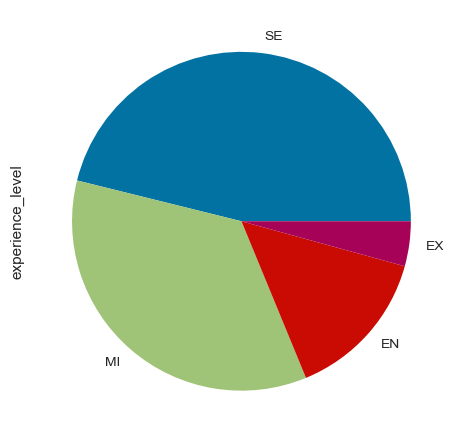

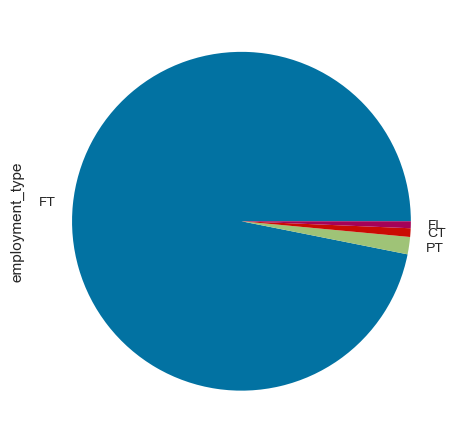

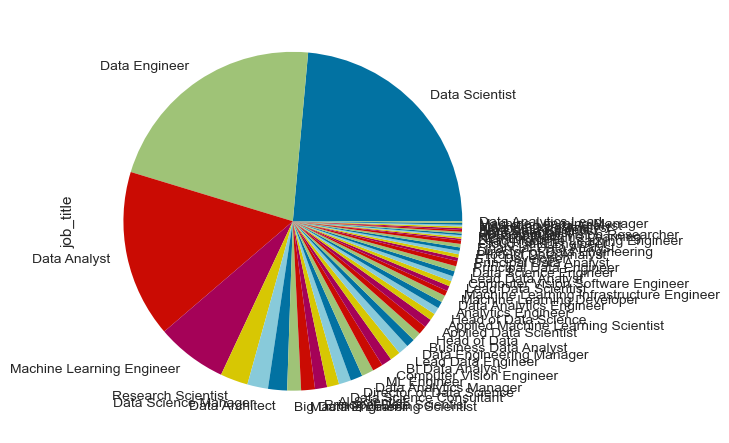

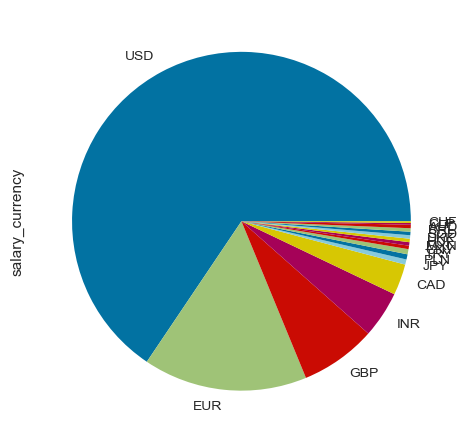

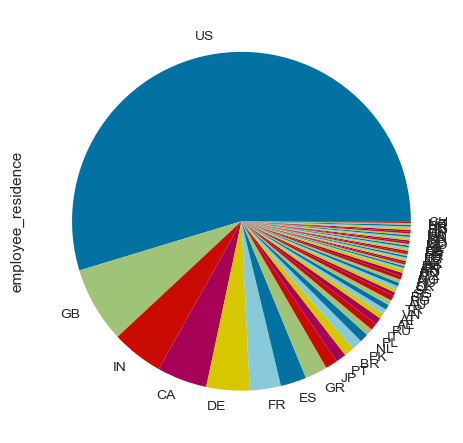

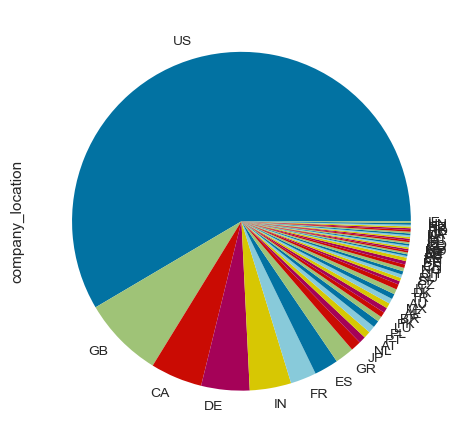

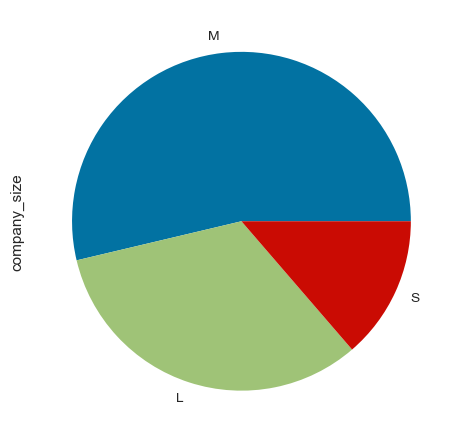

In [145]:
for col in data_3.select_dtypes('object'):
    plt.figure()
    data_3[col].value_counts().plot.pie()

**Interprétation :**
On constate que la plupart des salariés sont employés à temps plein et qu'une grande majorité sont d'un niveau junior ou senior. Une majorité concerne des entreprises de taille moyenne ou large. 

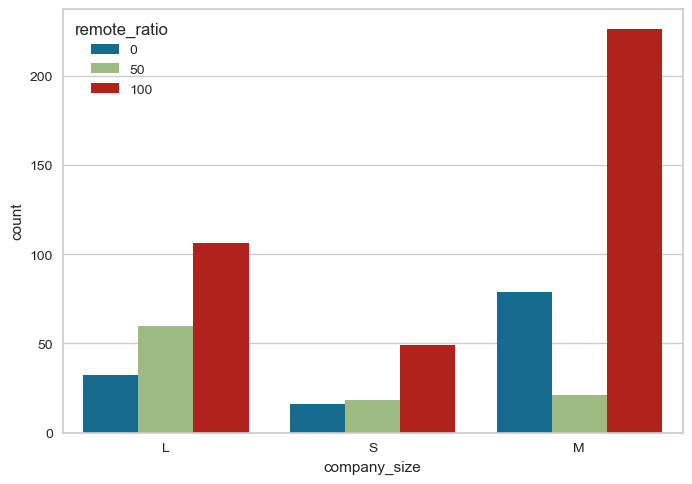

In [146]:
# Visualisation de remote_ration avec company_size

sns.countplot(x='company_size', hue='remote_ratio', data = data_3)
plt.show()

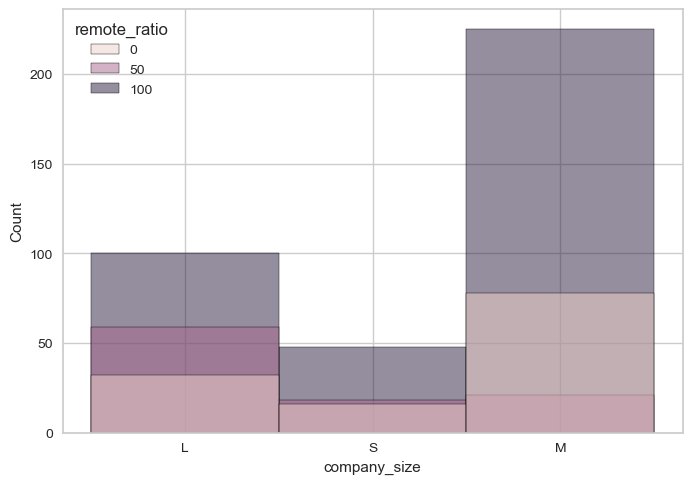

In [218]:
sns.histplot(data=data_3, x="company_size", hue = 'remote_ratio')
plt.show()
#  shrink =0.8, 

Les entreprises de moyenne taille ont tendance à pratiquer davantage de télétravail que les petites ou grandes entreprises (proportionnellement). 

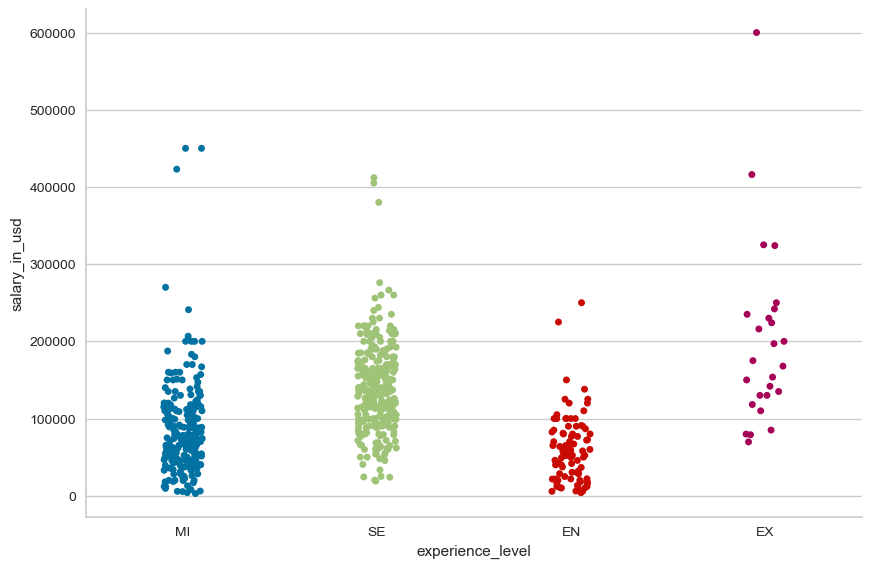

In [148]:
g = sns.catplot(x='experience_level', y='salary_in_usd', data=data_3)
g.fig.set_figwidth(10)
g.fig.set_figheight(6)

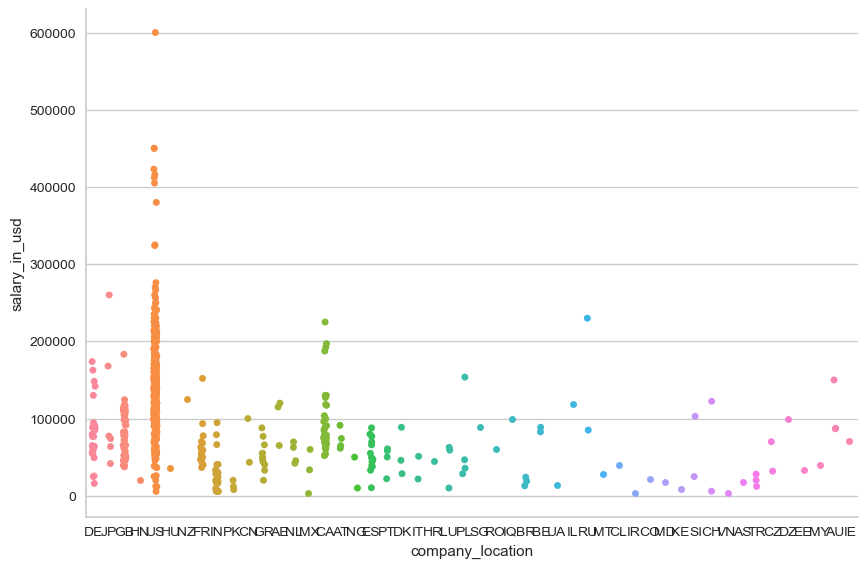

In [149]:
g = sns.catplot(x='company_location', y='salary_in_usd', data=data_3)
g.fig.set_figwidth(10)
g.fig.set_figheight(6)

### Corrélations entre les variables

#### Entre les variables numériques

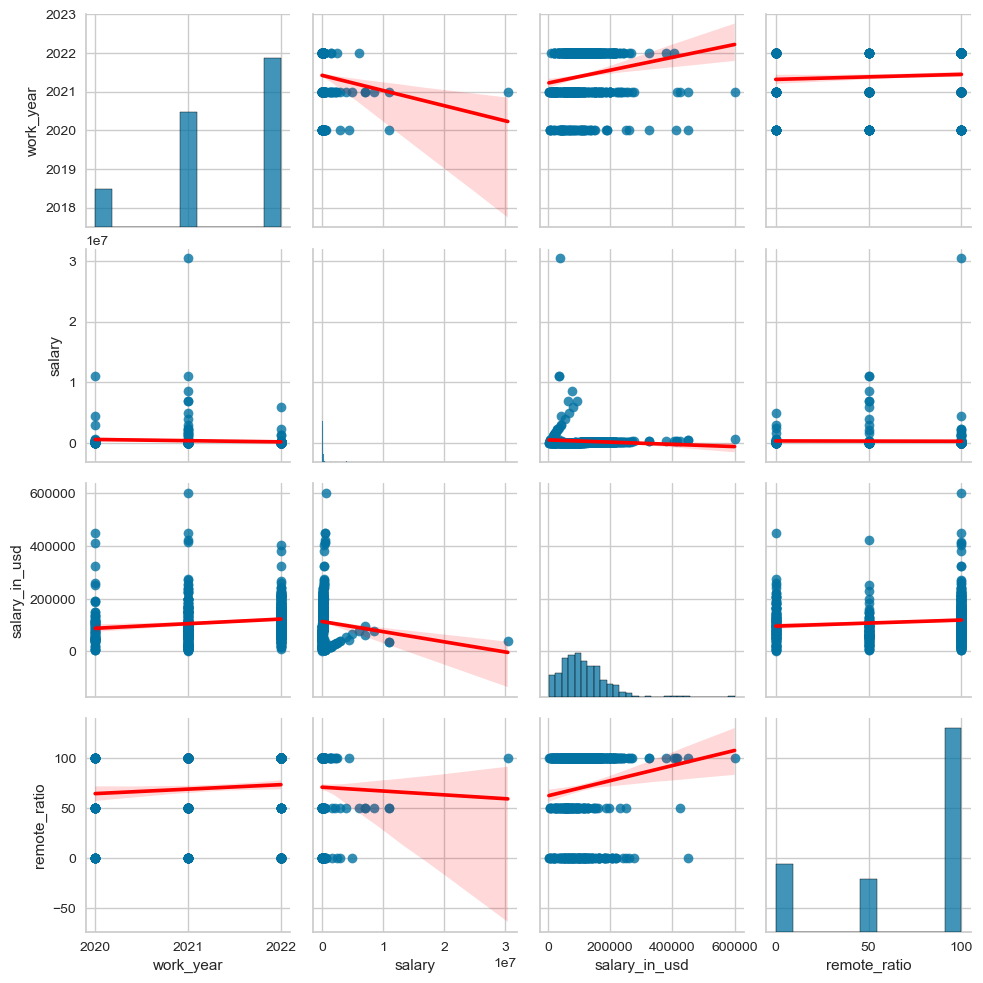

In [230]:
sns.pairplot(data_3, kind="reg", plot_kws={'line_kws':{'color':'red'}})
plt.show()

Les résultats du pairplot nous confirment que nous n'avons pas d'informations intéressantes s'agissant des variables numériques. Il pourrait être intéressant d'analyser de plus près le remote_ratio et le salaire.

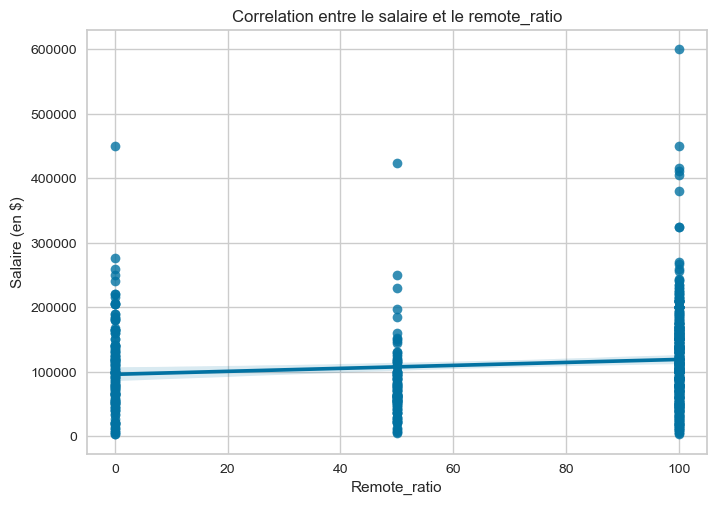

In [232]:
ax = sns.regplot(data=data_3,y='salary_in_usd', x='remote_ratio')
ax.set_title("Correlation entre le salaire et le remote_ratio")
ax.set_ylabel('Salaire (en $)')
ax.set_xlabel("Remote_ratio")
plt.grid(True)
plt.show()

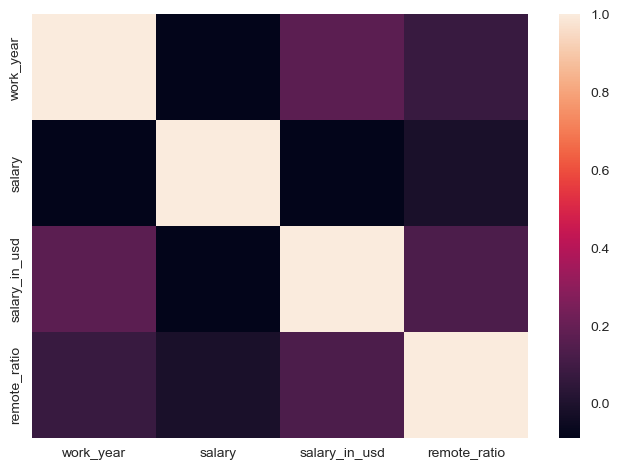

In [151]:
sns.heatmap(data_3.corr())
plt.show()

In [153]:
data_3.corr()

work_year    salary  salary_in_usd  remote_ratio
work_year       1.000000 -0.087577       0.170493      0.076314
salary         -0.087577  1.000000      -0.083906     -0.014608
salary_in_usd   0.170493 -0.083906       1.000000      0.132122
remote_ratio    0.076314 -0.014608       0.132122      1.000000

Plus une corrélation est proche de 1, plus une variable évolue positivement l'une et l'autre : quand l'une augmente, l'autre augmente aussi. 

Aucune variable n'est correlée entre elles, ni avec la target. Les résultats ne sont pas significatifs. Il ne semble y avoir aucune reation linéaire entre la target et ces variables.  
On constate une nouvelle fois la présence d'outliers. 

#### Entre les variables catégorielles

In [154]:
# Cross_tab
# Khi 2 : https://datascientest.com/correlation-entre-variables-comment-mesurer-la-dependance#:~:text=Corr%C3%A9lation%20entre%20deux%20variables%20cat%C3%A9gorielles%20%3A&text=Il%20s'agit%20d'une,deux%20variables%20test%C3%A9es%20sont%20ind%C3%A9pendantes%20%C2%BB.

#### Entre les variables catégorielles et la target

In [155]:
# Faire test Anova : http://www.python-simple.com/python-statsmodels/statsmodels-anova.php
# Anova : https://datascientest.com/correlation-entre-variables-comment-mesurer-la-dependance#:~:text=Corr%C3%A9lation%20entre%20deux%20variables%20cat%C3%A9gorielles%20%3A&text=Il%20s'agit%20d'une,deux%20variables%20test%C3%A9es%20sont%20ind%C3%A9pendantes%20%C2%BB.

#### Corrélation avec le feature engineering

Voir s'il est intéressant de faire du feature engineering mais pas de variables qui se sont particulièrement dégagées : 
- experience level en classe binaire (junior / intermediaire - expérimenté)
- company_location : salaire très élevé aux US + plus grand nombre de salariés => créer une classe binaire (1=US / 0=pas US)

In [156]:
data_3['company_location']

0      DE
1      JP
2      GB
3      HN
4      US
       ..
602    US
603    US
604    US
605    US
606    US
Name: company_location, Length: 607, dtype: object

In [157]:
data_3['company_location'][data_3['company_location'] != 'US'] = 0
data_3['company_location'][data_3['company_location'] == 'US'] = 1

In [158]:
data_3['company_location']

0      0
1      0
2      0
3      0
4      1
      ..
602    1
603    1
604    1
605    1
606    1
Name: company_location, Length: 607, dtype: object

In [159]:
data_3['company_location'].value_counts()

1    355
0    252
Name: company_location, dtype: int64

In [160]:
out_company_US = data_3[data_3['company_location'] == 0]
company_US = data_3[data_3['company_location'] == 1]

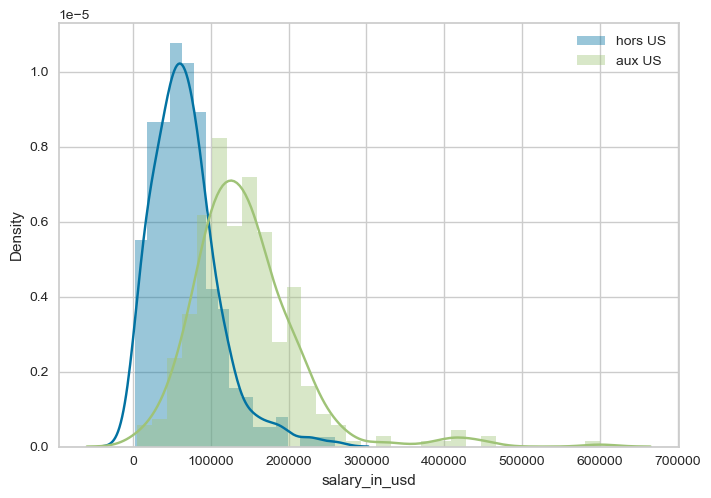

In [161]:
plt.figure()
sns.distplot(out_company_US['salary_in_usd'], label = 'hors US')
sns.distplot(company_US['salary_in_usd'], label = 'aux US')
plt.legend()
plt.show()

Après pre-processing, on note une différence de salaire entre les entreprises positionnées aux US et hors US. Cette nouvelle variable pourrait être intéressante car discriminante. 

In [234]:
# Tester la corrélation entre cette nouvelle feature et la target 

data_3['company_location'][data_3['company_location'] != 'US'] = 0
data_3['company_location'][data_3['company_location'] == 'US'] = 1
data_3 = data_3.astype({'company_location': int})

In [236]:
data_3.corr()

work_year    salary  salary_in_usd  remote_ratio  \
work_year          1.000000 -0.087577       0.170493      0.076314   
salary            -0.087577  1.000000      -0.083906     -0.014608   
salary_in_usd      0.170493 -0.083906       1.000000      0.132122   
remote_ratio       0.076314 -0.014608       0.132122      1.000000   
company_location   0.252017 -0.104826       0.531643      0.199119   

                  company_location  
work_year                 0.252017  
salary                   -0.104826  
salary_in_usd             0.531643  
remote_ratio              0.199119  
company_location          1.000000

Validons notre hypothèse par un T-test (code à reprendre)

In [162]:
from scipy.stats import ttest_ind

In [163]:
# Est sensible aux classes équilibrées => on va considérer que notre cas, c'est ok (252 vs 355)

out_company_US.shape, company_US.shape

((252, 11), (355, 11))

In [164]:
def t_test(col):
    alpha = 0.02
    stat, p = ttest_ind(out_company_US[col], company_US[col])
    if p < alpha:
        return 'H0 Rejetée'
    else :
        return 0

## Pre-processing

C'est à partir des analyses faites précédemment que l'on va prendre nos décisions pour cette 3ème itération :
- sélection des variables
- nettoyage
- encodage

### Sélection des variables 

In [166]:
# On repart sur un dataset vierge

data_3 = pd.read_csv('data/ds_salaries.csv', index_col=0)

Suite à la data visualisation, on décide de ne pas conserver toutes les variables du dataset : 
- 'salary' et 'salary_currency':  pas pertinente et risque de faire du vruit dans notre modèle
- 'employee_residence" : trop de modalités qui une fois encodées risquent de ralentir notre modèle et semble équivalent à 'company_location' qui a sera encodé manuellement. Avec l'application des modèles de régression (notre modèle), cela va créer trop de dimensions. 
- 'employment_type' : se poser la question de garder cette feature car classe complètement déséquilibrée
- 'work_year' : une date transformée en integer n'a pas d'intérêt dans notre projet

In [167]:
data_3 = data_3[['experience_level', 'employment_type', 'job_title', 'salary_in_usd',
                'remote_ratio', 'company_location', 'company_size']]

### Gestion des outliers

Notre modèle (la régression linéaire) étant très sensible aux outliers, il nous faut absolument les gérer. Dans notre cas, nous décidons de les supprimer. 

In [168]:
remove_outliers(data_3, data_3.select_dtypes(['integer', 'float']))

Old Shape:  (607, 7)
New Shape:  (597, 7)
Old Shape:  (597, 7)
New Shape:  (597, 7)


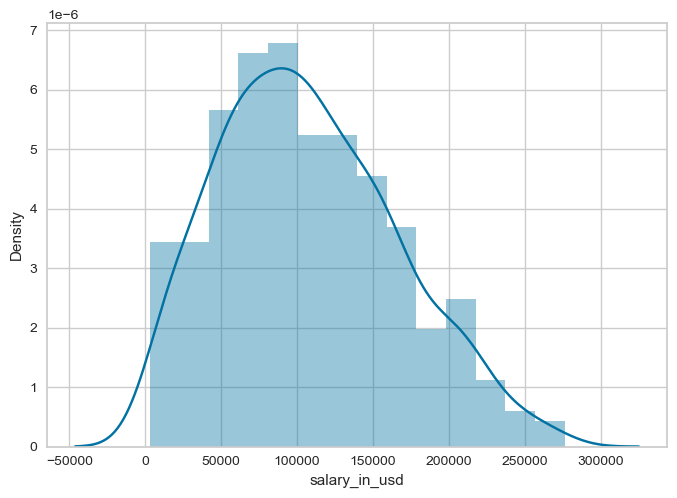

In [169]:
sns.distplot(data_3['salary_in_usd'], label = 'salary_in_usd')
plt.show()

Nous constatons que notre target qui présentait des valeurs aberrantes lors de l'analyse précédente n'en a plus. 

### Split TrainTest

Pour éviter tout data leakeage et préserver au maximum notre jeu de test (il ne faut jamais y toucher), nous splittons notre jeu de données dès à présent en 2 parties : un jeu de train et jeu de test. 

In [170]:
# On n'a pas conservé le test_size à 0.33 car nous n'avions pas assez de données d'entraînement

trainset, testset = train_test_split(data_3, test_size=0.2, random_state = 42)

In [171]:
trainset.shape, testset.shape

((477, 7), (120, 7))

### Preprocessing : encodage, normalisation, feature engineering & conversion

Nous avons encodé manuellement nos différentes variables de façon ordinale :  
- experience_level : comme fait dans les 1ères itérations 
- job_title : comme fait dans les 1ères itérations (suite à l'analyse de visualisation)
- employment_type : par soucis pratique (intégré dans la fonction directement) mais sera peut-être à onehotencoder ou à supprimer car les classes de cette variable sont très déséquilibrées => pas sûre qu'elles soient utiles au modèle. 
- company_size : on a attribué un poids à la variable en fonction de la taille 

Nous avons fait du feature engineering pour la variable company_location en créant une nouvelle colonne qui indiquait si la compagnie à laquelle appartenait le salarié était basée aux US ou non (suite aux résultats de notre visualisation). 

Nous avons converti la colonne salary_in_usd en kilo $ comme fait précédemment. 

Nous avons standardisé nos données (vérifier si cela a bien fonctionné) avec le Standarscaler (pour chaque variabl : moyenne égale à 0 et un écart-type de 1). Se poser la question de savoir si on doit standardiser quand toutes nos variables numériques sont des variables discrètes => avec standardisation des données ou pas, on obtient exactement le même résultat. 

In [201]:
X_train_3, y_train_3 = preprocessing(trainset)

In [202]:
X_test_3, y_test_3 = preprocessing(testset)

## ML - 3ème itération

Score R2 en cv : 0.5068519183391867
Score rmse en cv : -41.82700793133172
Score R2 sur le train : 0.5459287758904823


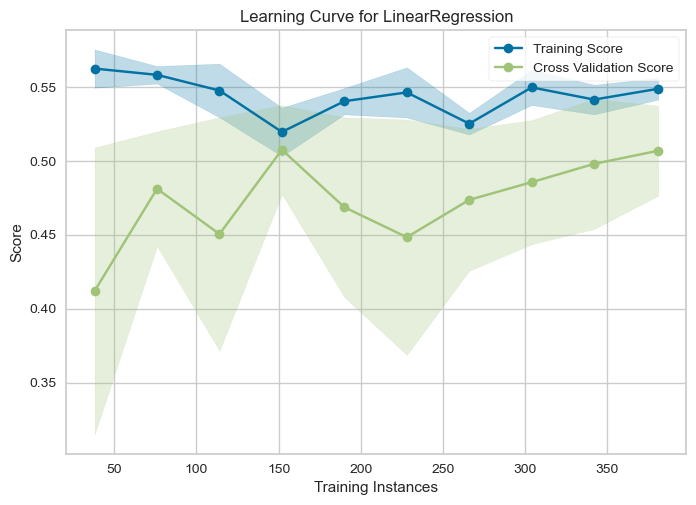

------------------------------------------------


In [203]:
iteration_3 = evaluation(model, X_train_3, y_train_3, X_test_3,y_test_3)

On constate une amélioration du score R2 et de la réduction des erreurs.  

In [204]:
# On score sur le test (avec des données qu'il n'a jamais vues)

model.score(X_test_3, y_test_3)

0.5385552216910108

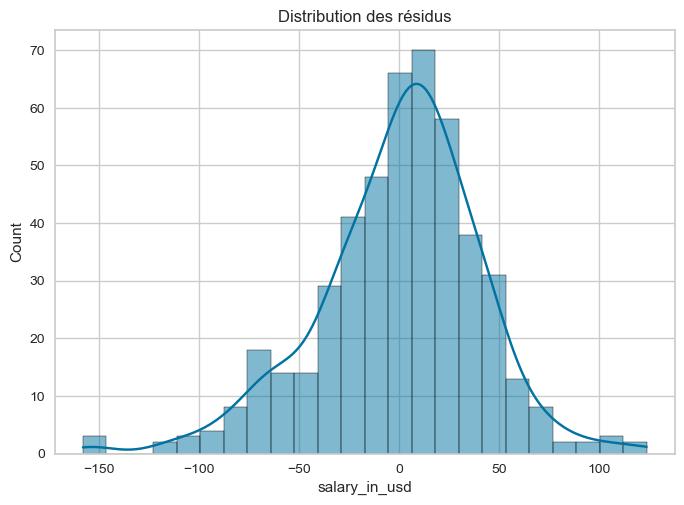

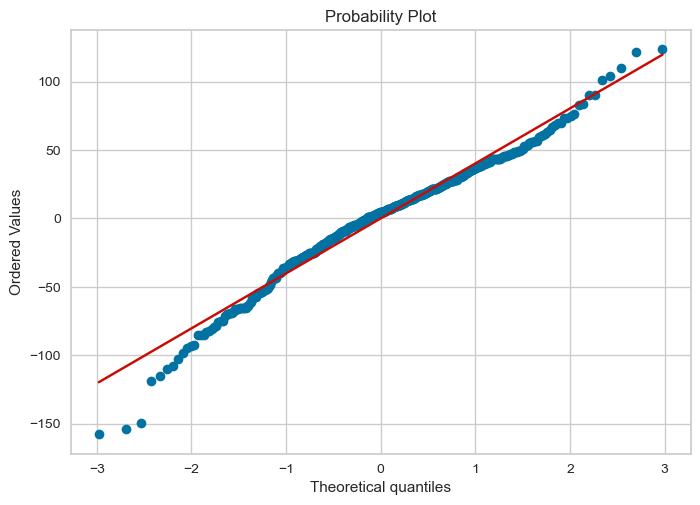

In [205]:
analyse_residus_linreg(model, X_train_3, y_train_3)

Les quantiles inférieurs s'éloignent quelque peu de la loi normale. Nos erreurs se situent essentiellement lorsqu'il s'agit de prédire les plus petits salaires. Il serait bon de pouvoir identifier les variables explicatives de ce phénomène. 

## Analyse des caractéristiques d'amélioration à apporter 

Notre dernière itération s'attachera à optimiser les hyperparamètres de la régression linéaire et de tester d'autres modèles. 

# - 4ème itération

Avant d'optimiser les hyperparamètres de la régression linéaire, on va s'assurer qu'un autre modèle n'obtiendrait pas de meilleurs scores. 

## Tester différents modèles

In [177]:
# J'instancie les modèles que je souhaite tester

lr = LinearRegression()
dt = DecisionTreeRegressor()
rf = RandomForestRegressor()
svr = SVR()

In [178]:
liste_modeles = [lr, dt, rf, svr]

Score R2 en cv : 0.5068519183391867
Score rmse en cv : -41.82700793133172
Score R2 sur le train : 0.5459287758904823


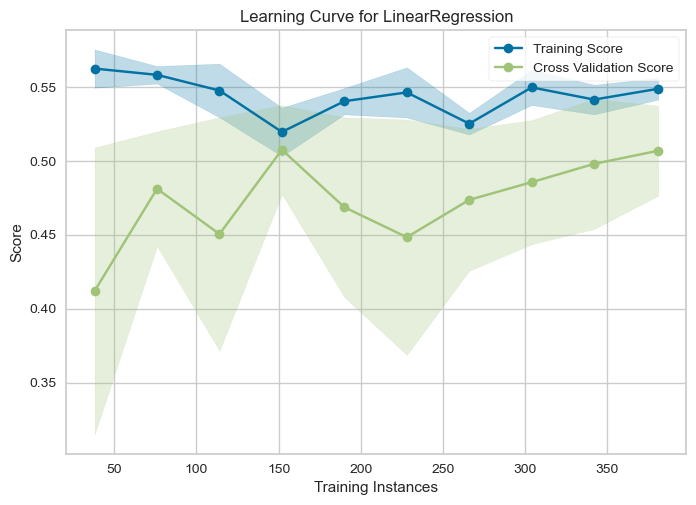

------------------------------------------------
Score R2 en cv : 0.04178061633517331
Score rmse en cv : -56.3908296905877
Score R2 sur le train : 0.8130574167712176


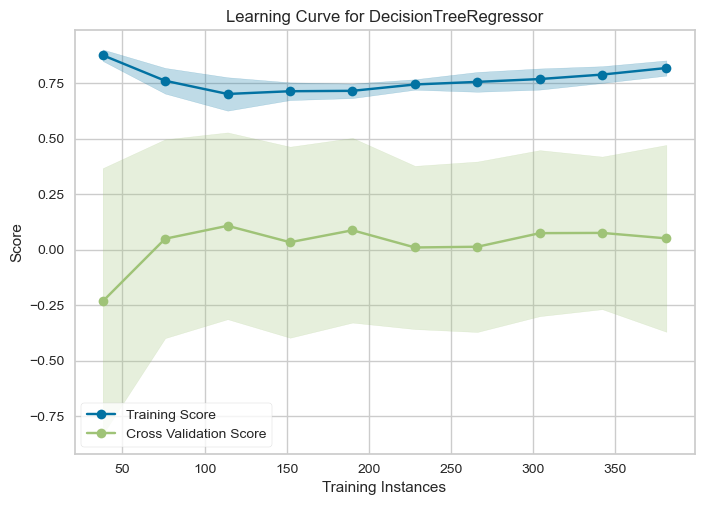

------------------------------------------------
Score R2 en cv : 0.29411281018858554
Score rmse en cv : -49.28795388921552
Score R2 sur le train : 0.7805730895760683


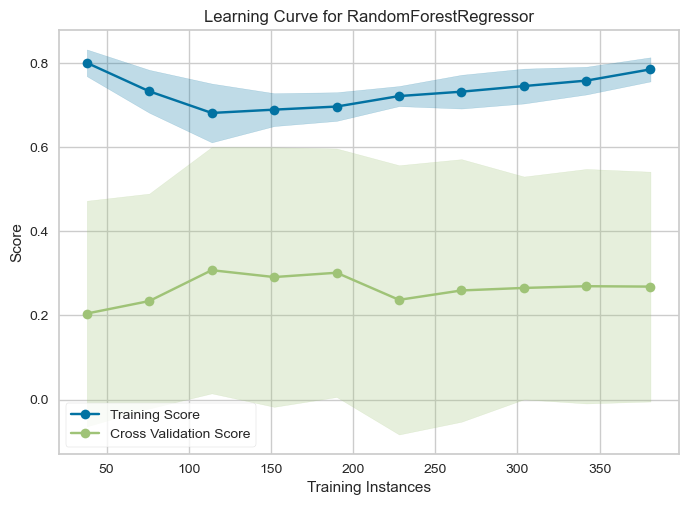

------------------------------------------------
Score R2 en cv : 0.040920676924412945
Score rmse en cv : -58.47347464323159
Score R2 sur le train : 0.06673798621149041


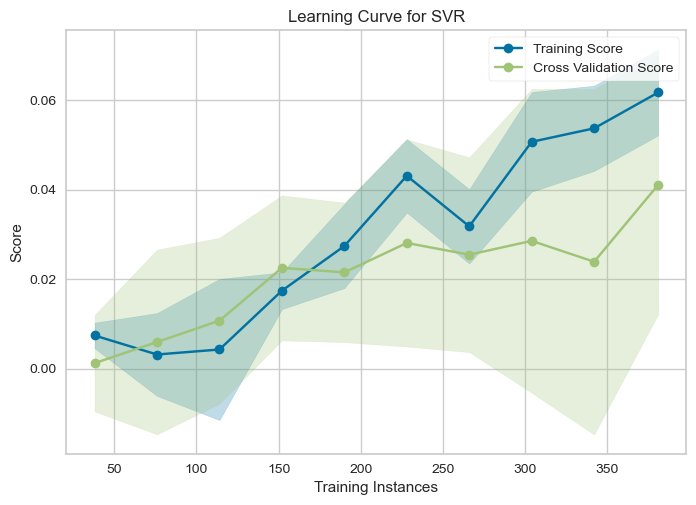

------------------------------------------------


In [179]:
for model in liste_modeles:
    evaluation(model, X_train_3, y_train_3, X_test_3, y_test_3)

C'est la régression linéaire qui généralise le mieux et qui obtient de meilleurs scores sur le test. Nous allons donc tenter d'optimiser les hyperparamètres de la régression liénaire. 

In [ ]:
iteration_1

## Optimisation des hyperparamètres

In [180]:
LinearRegression().get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [181]:
# On fait une liste des hyperparamètres à tester

params_lr = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False], 'n_jobs':[0, 1], 
           'positive':[True,False]}

grid = GridSearchCV(lr, param_grid=params_lr, cv=5)

grid.fit(X_train_3, y_train_3)

print(grid.best_params_)
print(grid.best_score_)

{'copy_X': True, 'fit_intercept': True, 'n_jobs': 0, 'normalize': False, 'positive': False}
0.5068519183391867


In [182]:
# Ne veux pas prendre le model_grid à cause du paramètre'n_jobs' = 0 => fait modèle manuellement


model_grid = grid.best_estimator_ # enregistre les meilleures performances

In [183]:
lr_params = LinearRegression(copy_X = True, fit_intercept = False, n_jobs = 1, normalize = True, positive = False)

Score R2 en cv : 0.5046405671027758
Score rmse en cv : -41.86653650109679
Score R2 sur le train : 0.539421592074248


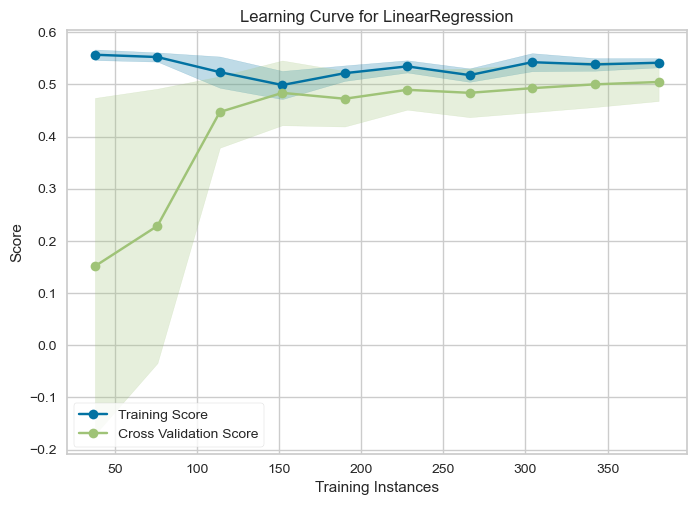

------------------------------------------------


In [184]:
evaluation(lr_params, X_train_3, y_train_3, X_test_3, y_test_3)

Quand on laisse les meilleurs paramètres par défaut, on obtient cette learning curve. Avec un score R2 qui a été dans le très grand négatif au début de l'entrainement. Mais quand on supprime le fit_intercept, on obtient une learning curve plus normale mais avec un R2 moins en cv moins bon => un modèle qui parvient un peu moins à généraliser (mais est très léger). 

In [185]:
lr_params_2 = LinearRegression(copy_X = True, n_jobs = 1, normalize = True, positive = False)

Score R2 en cv : 0.506851918339186
Score rmse en cv : -41.82700793133176
Score R2 sur le train : 0.5459287758904825


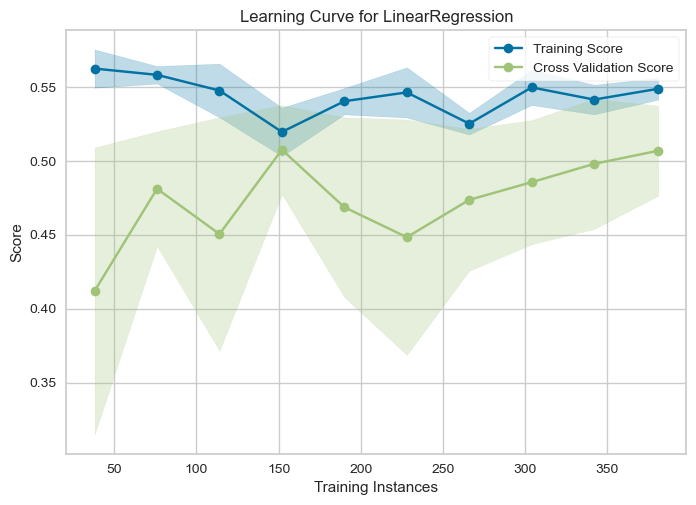

------------------------------------------------


In [186]:
evaluation(lr_params_2, X_train_3, y_train_3, X_test_3, y_test_3)

## Score du modèle sur le test et la dataset

In [187]:
# Score sur le test

lr_params_2.score(X_test_3, y_test_3)

0.53855522169101

In [188]:
# Score sur le dataset en intégralité

X, y = preprocessing(data_3)

In [189]:
model = lr_params_2.fit(X, y)
model.score(X, y)

0.5471937188341558

In [190]:
y_pred = model.predict(X)

In [ ]:
################
# A FAIRE (si temps)
# Intégrer un intervalle de confiance/de prédiction au modèle
###################

## Sauvegarde du modèle

In [ ]:
import joblib

In [ ]:
joblib.dump(model, 'model_joblib')

In [ ]:
model_joblib = joblib.load('model_joblib')

In [ ]:
prediction_joblib = model_joblib.predict(X)
prediction_joblib

# Dernières améliorations

- passer la target en logarithme (ou la revérifier après le retrait des outliers)